# Apartment Price Prediction Project

This project aims to predict apartment prices in major Polish cities using machine learning models. The dataset was scrapped by author (1.0-scrapping-real-estate.ipynb), cleaned, and enriched with additional features before applying various regression techniques and ensemble learning.

# Imports

In [ ]:
import os
import time
import random
import pickle
import joblib
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import setuptools.dist

from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import LinearRegression, Ridge, Lasso, RidgeCV
from sklearn.preprocessing import (
    StandardScaler,
    OneHotEncoder,
    KBinsDiscretizer,
    PolynomialFeatures,
    MinMaxScaler,
)
from sklearn.model_selection import (
    RandomizedSearchCV,
    StratifiedShuffleSplit,
    KFold,
)
from sklearn.metrics import (
    mean_squared_error,
    r2_score,
    mean_absolute_error as MAE,
    mean_absolute_percentage_error as MAPE,
)
from statsmodels.stats.outliers_influence import variance_inflation_factor

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Input,
    Dense,
    Activation,
    Dropout,
    BatchNormalization,
)
from tensorflow.keras.callbacks import (
    EarlyStopping,
    ModelCheckpoint,
    ReduceLROnPlateau,
)
from tensorflow.keras.optimizers import Adam

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from boruta import BorutaPy
from yellowbrick.target import ClassBalance
from ydata_profiling import ProfileReport

In [ ]:
# Display all columns in dataframe
pd.set_option("display.max_columns", None)

In [ ]:
# ignore warnings
warnings.filterwarnings("ignore", message="X does not have valid feature names")

In [13]:
def set_global_seed(seed):
    """Sets global seed for reproducibility."""
    tf.random.set_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

    print(f"Global seed set to: {seed}")


SEED = 42
set_global_seed(SEED)

Global seed set to: 42


In [14]:
def rmse(y_true, y_pred):
    """Calculate root mean squared error."""
    return np.sqrt(mean_squared_error(y_true, y_pred))


# Data Read

In [143]:
def load_data(filepath):
    """Loads dataset from a CSV file."""
    return pd.read_csv(filepath, index_col=0)

data_path = "../data/interim/all_cities_combined_anonymized_.csv"
df = load_data(data_path)

# Initial Data Cleaning and Train/Test Splitting

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 47973 entries, 0 to 47975
Data columns (total 23 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   estate              47973 non-null  object 
 1   transaction         47973 non-null  object 
 2   areaInSquareMeters  47973 non-null  float64
 3   roomsNumber         47973 non-null  object 
 4   dateModified        47973 non-null  object 
 5   dateOfCreation      47973 non-null  object 
 6   location            47935 non-null  object 
 7   price               43891 non-null  float64
 8   market              47973 non-null  object 
 9   advertiserType      47973 non-null  object 
 10  advertType          47973 non-null  object 
 11  buildYear           40653 non-null  float64
 12  buildingFloorsNum   45642 non-null  float64
 13  cityId              47973 non-null  int64  
 14  buildingOwnership   40130 non-null  object 
 15  buildingType        37172 non-null  object 
 16  construct

Missing values - location, buildYear, buildingsFloorsNum, buildingOwnership, buildingType, constructionStatus, extrasTypes outdoor heating freeFrom.

7 features are numerical, 15 categorical

In [ ]:
# Checking categorical columns with <8 variables, indicate those that can be deleted:
columns = df.select_dtypes(include=["object"])
for i in columns:
    values_dict = {}
    unique_values = df[i].value_counts()
    if len(unique_values) < 8:
        # values_dict.
        print(unique_values)

estate
FLAT    47973
Name: count, dtype: int64
transaction
SELL    47973
Name: count, dtype: int64
market
SECONDARY    27643
PRIMARY      20330
Name: count, dtype: int64
advertiserType
business    43329
private      4644
Name: count, dtype: int64
advertType
AGENCY            34971
DEVELOPER_UNIT     7796
PRIVATE            5206
Name: count, dtype: int64
buildingOwnership
['full_ownership']       37020
['limited_ownership']     2873
['share']                  157
['usufruct']                80
Name: count, dtype: int64
buildingType
['block']        20632
['apartment']    10995
['tenement']      4736
['ribbon']         391
['house']          277
['infill']          95
['loft']            46
Name: count, dtype: int64
constructionStatus
['ready_to_use']     18758
['to_completion']    17874
['to_renovation']     2769
Name: count, dtype: int64
outdoor
balcony    29078
garden      3401
terrace     2350
Name: count, dtype: int64
heating
urban          28026
gas             3370
other          

In [144]:
# Dropping features that won't contribute to the test, either one value for whole dataset, too many categories, categories hard to fil NaNs or too many NaN values
def drop_data(df):
    """Remove unnecessary data."""
    # Delete NA price since this value we're going to predict
    df = df.dropna(axis=0, subset=["price"], ignore_index=False)
    # Dropping house building types, since we are suppose to only predict flats
    df = df.drop(df[df["buildingType"] == "['house']"].index)
    df = df.drop(
        columns=[
            "estate",
            "transaction",
            "dateModified",
            "dateOfCreation",
            "cityId",
            "heating",
            "extrasTypes",
            "freeFrom",
        ],
        axis=1,
    )

    return df


df = drop_data(df)

In [26]:
def cleaning_data(df):
    """Clean categorical values."""
    for col in ["buildingOwnership", "buildingType", "constructionStatus"]:
        df[col] = df[col].replace([r"\[", r"\]", r"\'"], "", regex=True)
    return df


df = cleaning_data(df)

In earlier scraping stage all duplicates were removed based on offers id - no need to search for duplicates.

Based on data understanding - location is a very important factor for flats price, therefore it will be extracted from location features and used for strattified shuffle split.

In [145]:
def split_location(df):
    """Extract location details."""
    df[["subdivision", "district", "city"]] = (
        df["location"].str.split(", ", expand=True).iloc[:, :3]
    )
    df.drop(columns=["location"], inplace=True)
    cities_to_keep = ["Wrocław", "Warszawa", "Poznań", "Kraków", "Łódź"]
    df = df[df["city"].isin(cities_to_keep)]
    return df


df = split_location(df)

In [146]:
def stratify(df):
    """Add 'stratified' column for splitting."""
    df["price_cat"] = pd.qcut(df["price"], q=3, labels=False)
    df["areaInSquareMeters_cat"] = pd.qcut(df["areaInSquareMeters"], q=3, labels=False)
    df["buildYear_cat"] = pd.qcut(df["buildYear"], q=3, labels=False)
    df["stratified"] = (
        df["price_cat"].astype(str)
        + "_"
        + df["areaInSquareMeters_cat"].astype(str)
        + "_"
        + df["buildYear_cat"].astype(str)
        + "_"
        + df["city"].astype(str)
    )

    strat_counts = df["stratified"].value_counts()
    one_value_strat = strat_counts[strat_counts == 1].index.tolist()

    for category in one_value_strat:
        df.loc[df["stratified"] == category, "stratified"] = "other"

    return df


def split(df):
    """Split dataset into stratified train and test sets."""
    split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=SEED)

    for train_index, test_index in split.split(df, df["stratified"]):
        strat_train_set = df.iloc[train_index]
        strat_test_set = df.iloc[test_index]

    columns_to_drop = [
        "stratified",
        "price_cat",
        "areaInSquareMeters_cat",
        "buildYear_cat",
    ]
    strat_train_set = strat_train_set.drop(columns=columns_to_drop)
    strat_test_set = strat_test_set.drop(columns=columns_to_drop)

    return strat_train_set, strat_test_set

In [147]:
strat_train_set, strat_test_set = split(stratify(df))
df = df.drop(
    columns=["stratified", "price_cat", "areaInSquareMeters_cat", "buildYear_cat"]
)

# EDA

## Visualization of categotical values

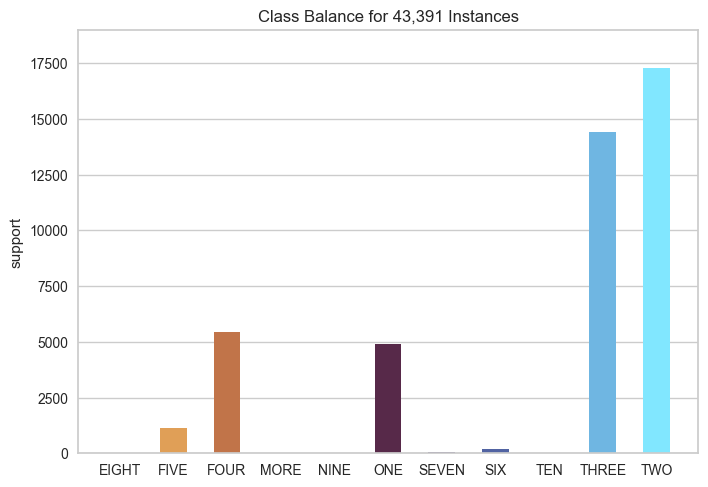

Percentage of 2 and 3 rooms: 72.99%


In [148]:
# Rooms distribution

visualizer = ClassBalance(colormap="managua")
visualizer.fit(df["roomsNumber"])
visualizer.show()

percentage = (
    ((df["roomsNumber"] == "THREE").sum() + (df["roomsNumber"] == "TWO").sum())
    / len(df)
    * 100
)
print(f"Percentage of 2 and 3 rooms: {percentage:.2f}%")

Vast majority is categorized as a 2 or 3 rooms flats, over 70%

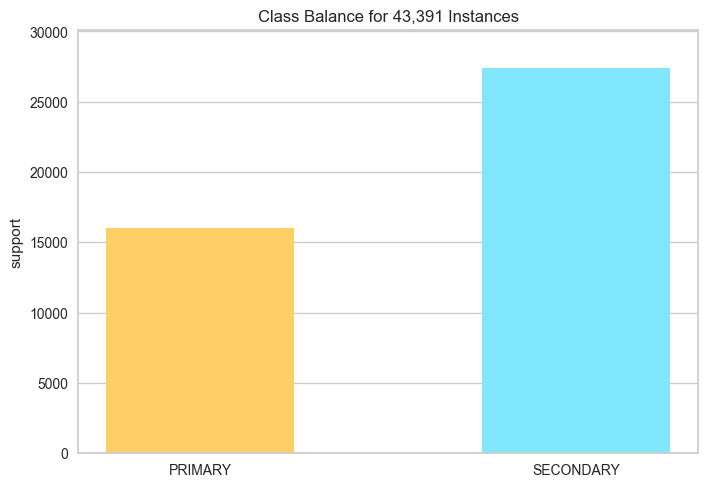

Percentage of 'SECONDARY' market: 63.11%


In [149]:
# Market ditribution

visualizer = ClassBalance(colormap="managua")
visualizer.fit(df["market"])
visualizer.show()

percentage_secondary = (df["market"] == "SECONDARY").sum() / len(df) * 100
print(f"Percentage of 'SECONDARY' market: {percentage_secondary:.2f}%")

Over 60% of flats belongs to a secondary market.

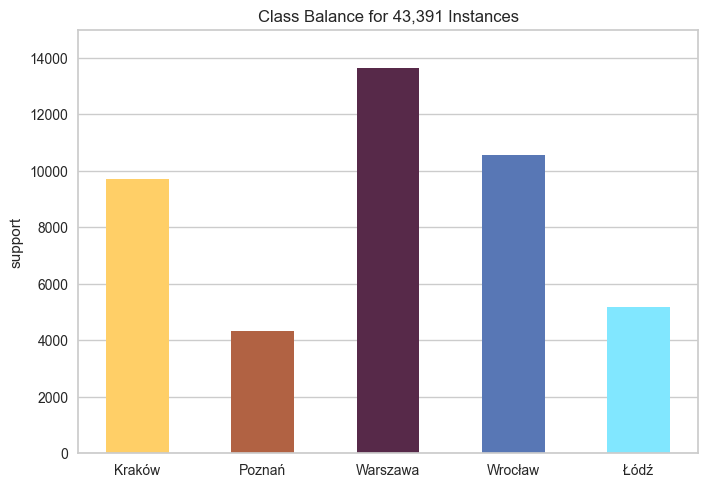

<Axes: title={'center': 'Class Balance for 43,391 Instances'}, ylabel='support'>

In [150]:
# Cities distribution

visualizer = ClassBalance(colormap="managua")
visualizer.fit(df["city"])
visualizer.show()

In [16]:
df.describe()

areaInSquareMeters         price     buildYear  buildingFloorsNum  \
count        43391.000000  4.339100e+04  36491.000000       41121.000000   
mean            57.785955  8.899724e+05   2000.006906           5.597335   
std             68.459732  7.137054e+05    260.204207           3.717802   
min             10.000000  1.297040e+03      1.000000           1.000000   
25%             40.400000  5.633165e+05   1979.000000           3.000000   
50%             51.710000  7.328690e+05   2017.000000           4.000000   
75%             66.000000  9.700000e+05   2024.000000           7.000000   
max          12500.000000  2.000000e+07  32767.000000         111.000000   

           latitude     longitude  
count  43391.000000  43391.000000  
mean      51.435970     19.208740  
std        0.868170      1.683704  
min       49.976250     16.814885  
25%       51.065740     17.037560  
50%       51.752690     19.912784  
75%       52.231170     20.952002  
max       52.490041     21.251730

(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5]),
 [Text(0, 0.5, 'areaInSquareMeters'),
  Text(0, 1.5, 'price'),
  Text(0, 2.5, 'buildYear'),
  Text(0, 3.5, 'buildingFloorsNum'),
  Text(0, 4.5, 'latitude'),
  Text(0, 5.5, 'longitude')])

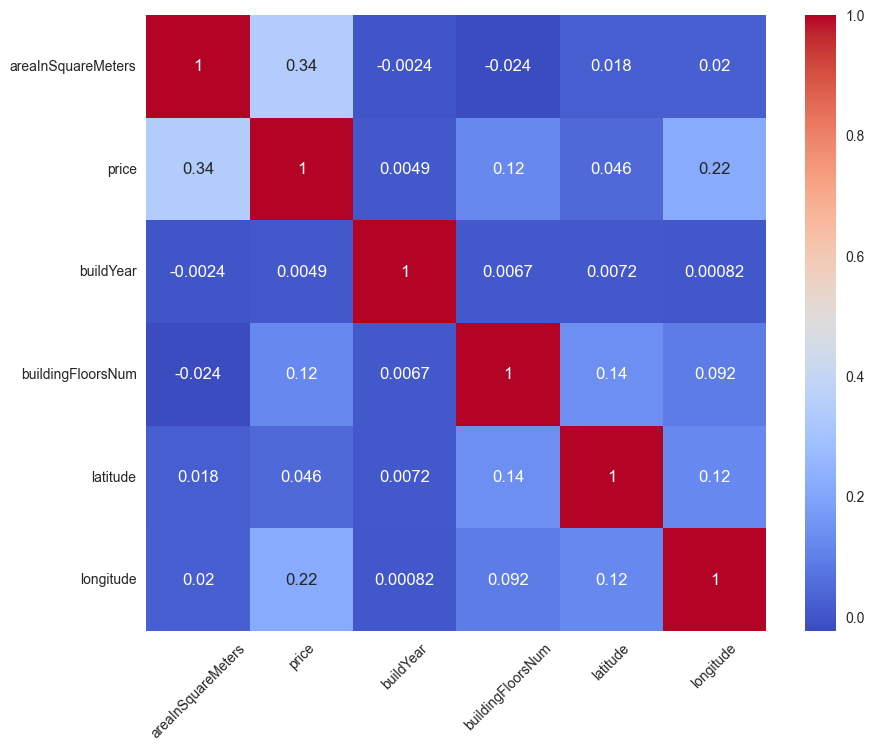

In [15]:
# Correlatiom Matrix Visualization - Heatmap

plt.figure(figsize=(10, 8))
correlations_matrix = df.corr(numeric_only=True)
sns.heatmap(correlations_matrix, annot=True, cmap="coolwarm")
plt.xticks(rotation=45)
plt.yticks(rotation=0)

Dependent variable - price, shows more signifficant correlation for: area, latitude and longitude.

## Outliers

<Axes: >

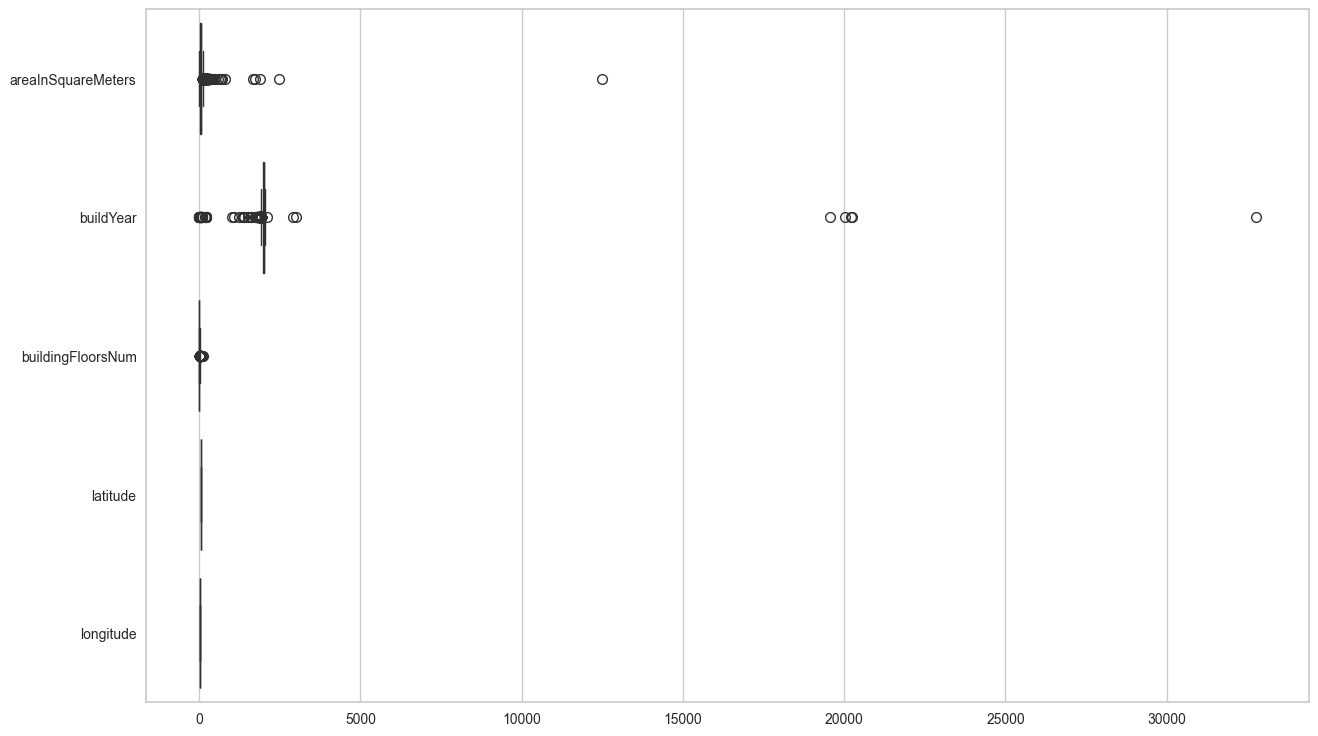

In [17]:
# visualizing outliers
plt.figure(figsize=(15, 9))
sns.boxplot(df.select_dtypes(include=np.number).drop(columns=["price"]), orient="h")

There are some signifficant outliers in dataset, mainly areaInSquareMeters and buildYear.


In areaInSquareMeeters some outliers shows positions that are wrongly classified or have errors in data. The biggest appartments in Poland are around 300 square meters. 

In buildYear we have a similar situation, flats should be casegorized as built between 1930-2050.

In [151]:
def remove_outliers_iqr(df, column="areaInSquareMeters"):
    """Remove outliers using IQR method."""
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Filter out outliers
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]


df_out = remove_outliers_iqr(df)  # For visualization purpose

In [152]:
def remove_outliers_iqr(df, column="price"):
    """Remove outliers using IQR method."""
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Filter out outliers
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]


df_out = remove_outliers_iqr(df_out)  # For visualization purpose

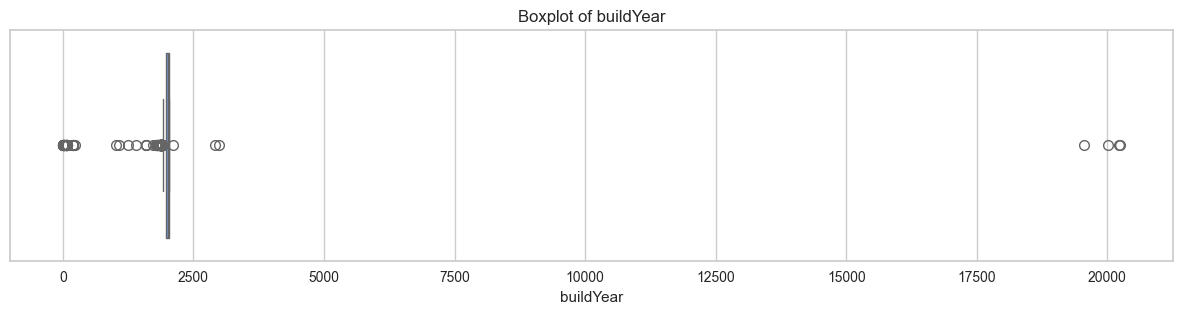

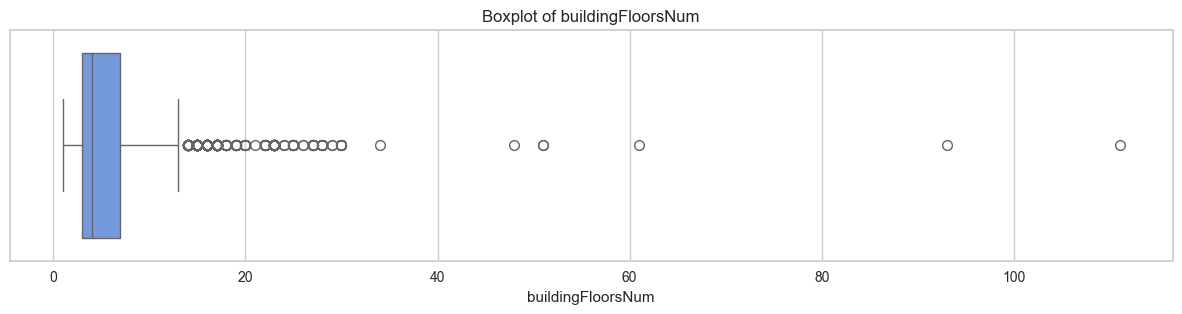

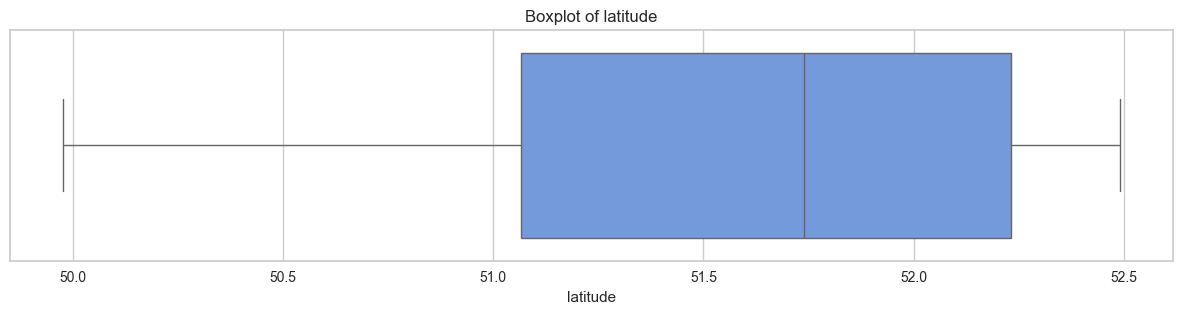

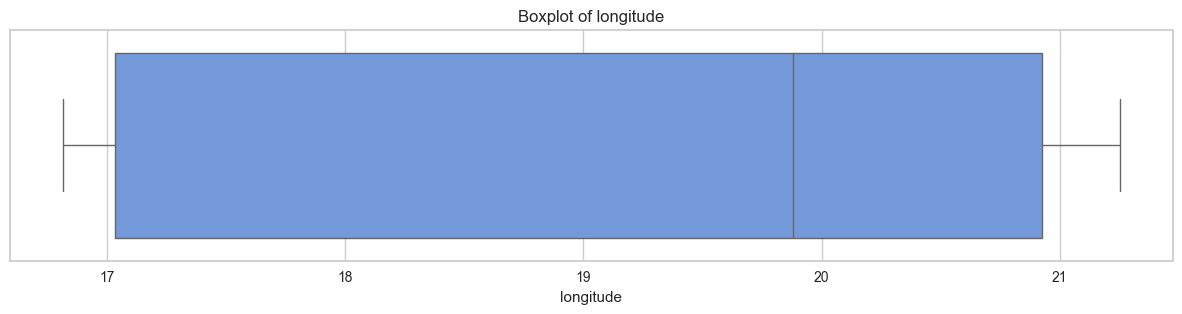

In [153]:
# Boxplot to detect outliers and see the spread
numeric = (
    df_out.select_dtypes(include=np.number).drop(columns=["price"]).columns.tolist()
)
for i in numeric:
    plt.figure(figsize=(15, 3))
    sns.boxplot(x=df_out[i], color="cornflowerblue")
    plt.title(f"Boxplot of {i}")
    plt.xlabel(i)
    plt.show()

## Data Distribution Analysis

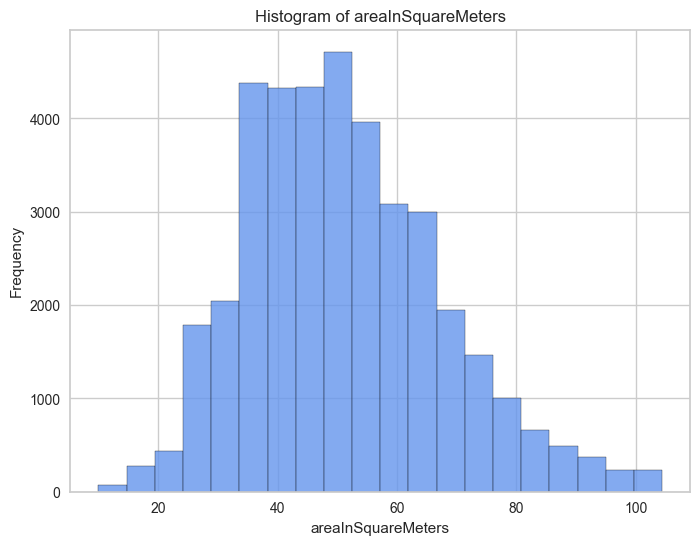

In [154]:
# Histogram to visualize the data distribution on percentile-based capped dataset
numeric = (
    df_out.select_dtypes(include=np.number)
    .drop(columns=["latitude", "longitude"])
    .columns.tolist()
)
for i in numeric:
    plt.figure(figsize=(8, 6))
    plt.hist(df_out[i], bins=20, color="cornflowerblue", edgecolor="black", alpha=0.8, label=i)
    plt.title(f"Histogram of {i}")
    plt.xlabel(i)
    plt.ylabel("Frequency")
    plt.show()

The area histogram is nearly normal (bell-shaped). Log transformation is not necessary because normalizing an already normal feature is not useful.

The price histogram is skewed with a tail on the right. It won't be logarithmically transformed, since we need to keep the model easily interpretable.

The building floors histogram is right-skewed with extreme values. Logarithimc transformation or binning might be an option.

Build Year - Log transformation is NOT suitable for categorical or time-based features.

In [34]:
# ProfileReport
prof = ProfileReport(df)
prof.to_file(output_file='ProfileReport_df.html')

Export report to file: 100%|██████████| 1/1 [00:00<00:00, 83.99it/s]


## Mapping Categorical Variables, Filling Missing Values

In [155]:
def ownership_mapping(df):
    """Map building ownership."""
    df.loc[:, "buildingOwnership"] = np.where(
        df["buildingOwnership"] == "full_ownership", 1, 0
    )
    df["buildingOwnership"] = df["buildingOwnership"].astype(int)
    return df


def map_na(df):
    """Fill missing values for outdoor and construction status."""
    df["outdoor"] = df["outdoor"].fillna("None")
    df["constructionStatus"] = df["constructionStatus"].fillna("None")
    return df


def mapping(df):
    """Map categorical values. market, advertiserType, advertType, rooms"""
    dict_map = {
        "PRIMARY": 1,
        "SECONDARY": 0,
        "business": 1,
        "private": 0,
        "DEVELOPER_UNIT": 1,
        "AGENCY": 1,
        "PRIVATE": 0,
        "ONE": 1,
        "TWO": 2,
        "THREE": 3,
        "FOUR": 4,
        "FIVE": 5,
        "SIX": 6,
        "SEVEN": 7,
        "EIGHT": 8,
        "NINE": 9,
        "TEN": 10,
        "MORE": 10,
    }

    df["market"] = df["market"].map(dict_map)
    df["advertiserType"] = df["advertiserType"].map(dict_map)
    df["advertType"] = df["advertType"].map(dict_map)
    df["roomsNumber"] = df["roomsNumber"].map(dict_map)
    return df


def price_scaling(df):
    """Scale price to kPLN."""
    df["price"] = df["price"] / 1000
    df["price"] = df["price"].round(2)
    return df

In [156]:
# Compute median and mode using only the training set
buildYear_median = strat_train_set["buildYear"].median()
buildingFloorsNum_median = strat_train_set["buildingFloorsNum"].median()
buildingType_mode = strat_train_set["buildingType"].mode()[0]

# Identify rare values (< 5%) based on training set
value_counts = strat_train_set["buildingType"].value_counts(normalize=True)
rare_values = value_counts[value_counts < 0.05].index


def fill_na(df):
    """Fill missing values."""
    df.loc[(df["buildYear"] > 2050) | (df["buildYear"] < 1930), "buildYear"] = np.nan
    df["buildYear"] = df["buildYear"].fillna(buildYear_median)
    df["buildingFloorsNum"] = df["buildingFloorsNum"].fillna(buildingFloorsNum_median)
    df["buildingType"] = df["buildingType"].replace(rare_values, buildingType_mode)
    df["buildingType"] = df["buildingType"].fillna(buildingType_mode)

    return df

In [157]:
# Compute mode only from the training set
buildingType_mode = strat_train_set["buildingType"].mode()[0]


def fill_buildingType(df):
    """Fill missing buildingType values."""
    df.loc[:, "buildingType"] = df["buildingType"].fillna(buildingType_mode)
    return df

In [158]:
def mapping_priceScaling(df):
    """Apply mappings and scaling."""
    ownership_mapping(df)
    map_na(df)
    price_scaling(df)
    mapping(df)
    fill_na(df)
    fill_buildingType(df)
    return df

In [159]:
df_out_map = mapping_priceScaling(df_out)  # For visualization purpose
train_map = mapping_priceScaling(strat_train_set)
test_map = mapping_priceScaling(strat_test_set)

buildYear buildingFloorsNum had missing values as numerical features.

Most of models can't operate on dataframe with missing values, so they were filled in.

In [160]:
def log(df):
    """Apply log transformation to buildingFloorsNum."""
    df["buildingFloorsNumLog"] = np.log1p(df["buildingFloorsNum"])
    return df


df_out_map = log(df_out_map)  # For visualization purpose
train_map = log(train_map)
test_map = log(test_map)

In [28]:
sns.pairplot(
    df_out_map[["city", "price", "roomsNumber", "areaInSquareMeters"]],
    hue="city",
    height=2.5,
    plot_kws={"alpha": 0.5},
)

Łódź city have signifficantly lover area/price rate.

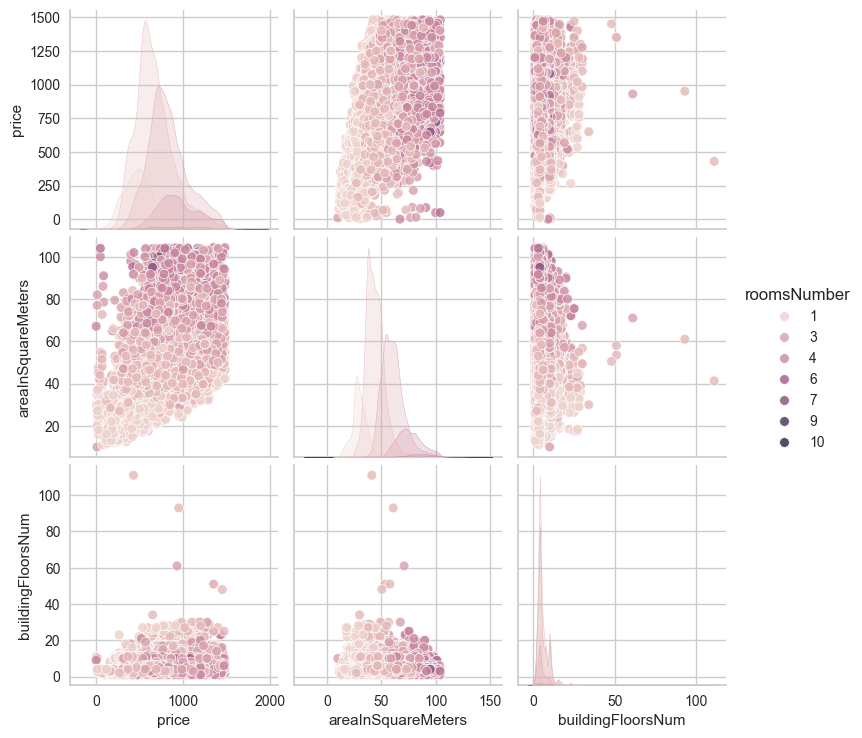

In [168]:
sns.pairplot(
    df_out_map[["price", "roomsNumber", "areaInSquareMeters", "buildingFloorsNum"]],
    hue="roomsNumber",
    height=2.5,
    plot_kws={"alpha": 0.8},
)

In [30]:
sns.pairplot(
    df_out_map[
        ["price", "market", "roomsNumber", "areaInSquareMeters", "constructionStatus"]
    ],
    hue="constructionStatus",
    height=2.5,
    plot_kws={"alpha": 0.5},
)

to_renovation flats tend to be cheaper and price isn't growing rapidly with increasing area

(1) primary market mostly to_completion status

(0) secondary market mostly ready_to_use status, there are a signifficantly less to_renovation and to_completion

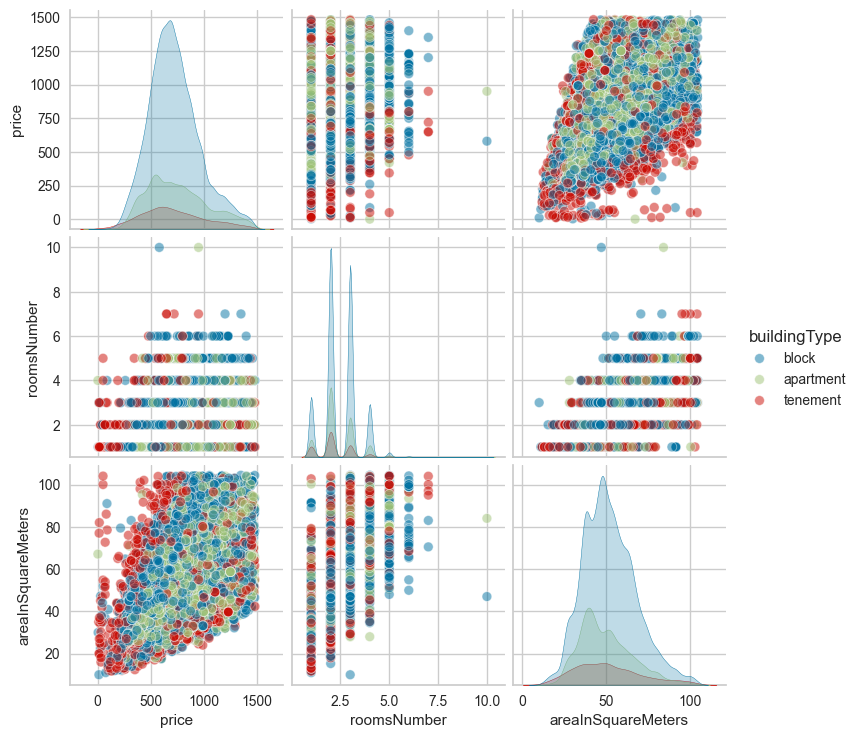

In [31]:
sns.pairplot(
    df_out_map[["price", "roomsNumber", "areaInSquareMeters", "buildingType"]],
    hue="buildingType",
    height=2.5,
    plot_kws={"alpha": 0.5},
)

We see different behavior area / privce / building type.  Price grows rapidly for apartments, less so for block, and even less for tenement.

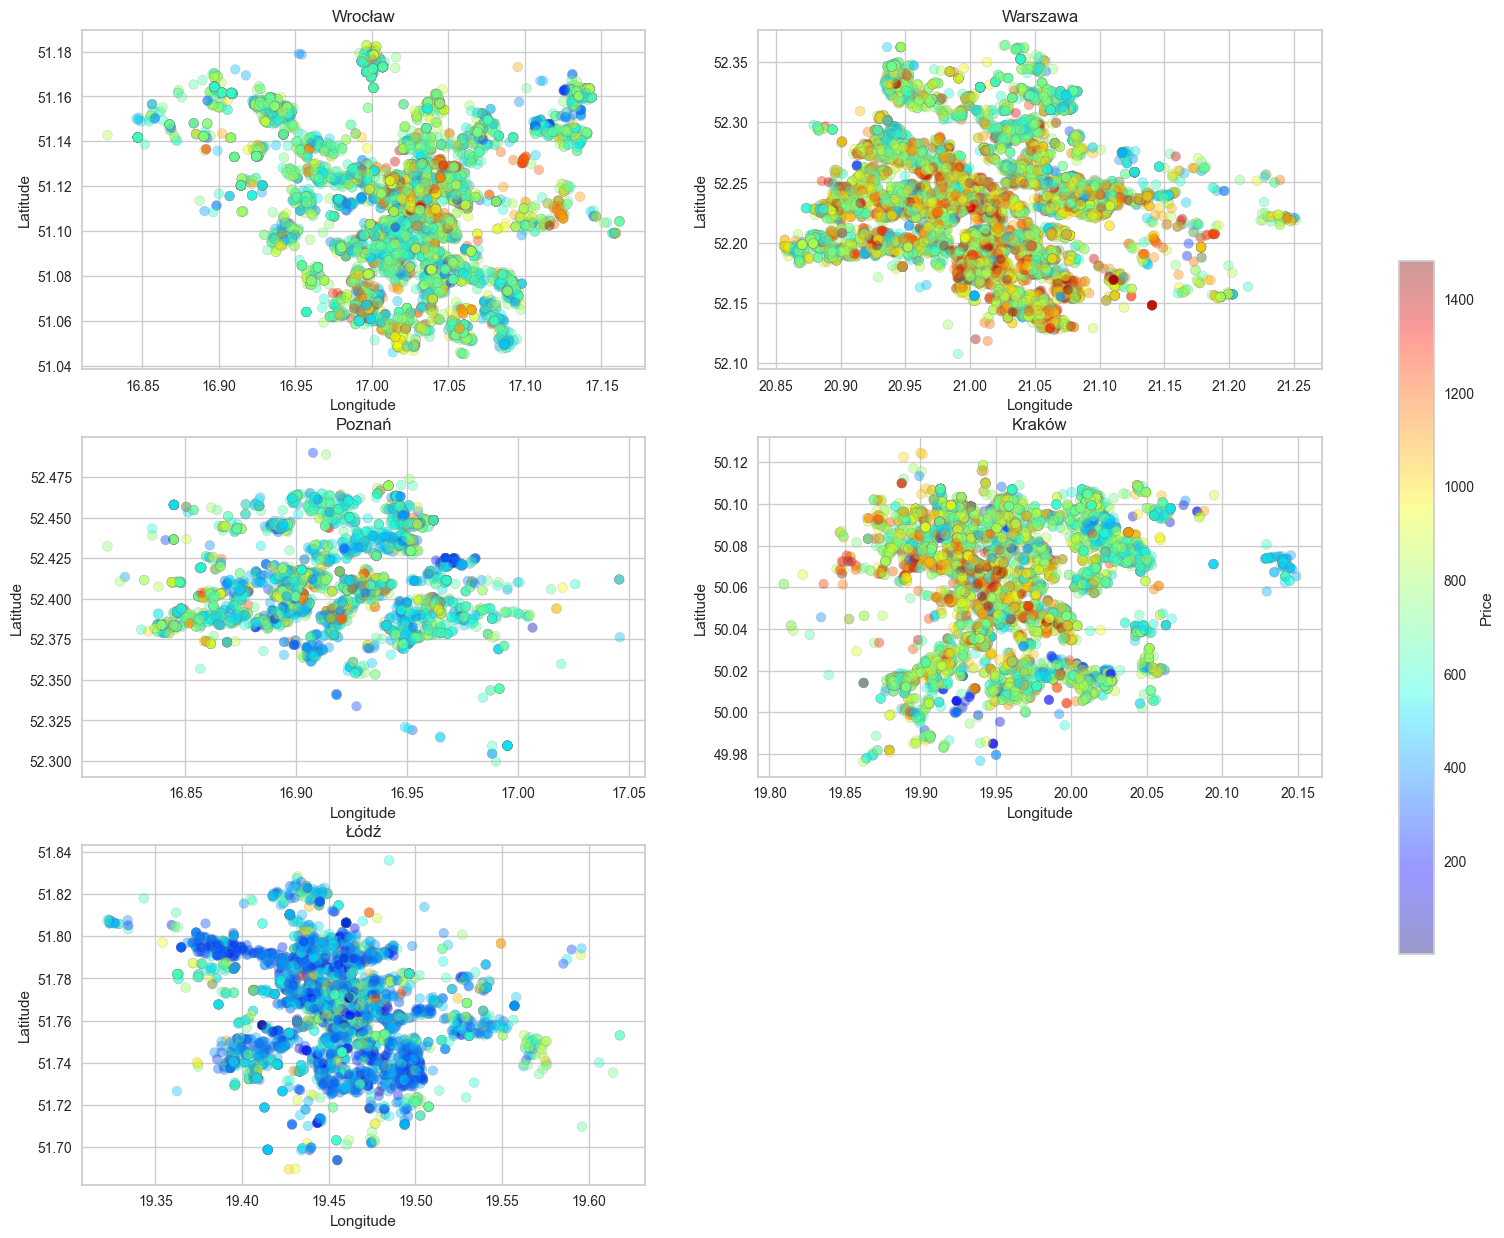

In [ ]:
# Plotting geographical position of flats per city with color mapping of price

# Get list of unique cities
cities = list(df_out_map["city"].unique())

# Define subplot grid dynamically
rows, cols = (len(cities) // 2) + 1, 2

# Get global min & max price for consistent color scale
vmin = df_out_map["price"].min()
vmax = df_out_map["price"].max()

# Define axes array
fig, axes = plt.subplots(rows, cols, figsize=(20, 15))

# Flatten axes array for easy iteration
axes = axes.flatten()

# Loop through cities and plot
for i, city in enumerate(cities):
    city_data = df_out_map[df_out_map["city"] == city]
    scatter = axes[i].scatter(
        city_data["longitude"],
        city_data["latitude"],
        alpha=0.4,
        edgecolors="tab:gray",
        c=city_data["price"],
        cmap="jet",
        vmin=vmin,
        vmax=vmax,
    )
    axes[i].set_title(city)
    axes[i].set_xlabel("Longitude")
    axes[i].set_ylabel("Latitude")

# Remove empty subplots (if cities < total subplot slots)
if len(axes) > i + 1:
    fig.delaxes(axes[-1])


cbar = fig.colorbar(scatter, ax=axes, orientation="vertical", shrink=0.6)
cbar.set_label("Price")

plt.show()

Each city has a unique distribution of housing density and housing prices.

# Feature Engineering

## Aggregation / Binning 

In [173]:
# Compute bin edges from training set only
quantiles = pd.qcut(train_map["buildYear"], q=4, duplicates="drop", retbins=True)[1]


def buildYearBins(df, bins):
    """Bin buildYear into categories."""
    df.loc[:, "buildYear_bins"] = (
        pd.cut(
            df["buildYear"],
            bins=bins,
            labels=range(1, len(bins)),  # Adjust labels dynamically
            include_lowest=True,
        )
        .astype("category")
        .cat.codes
    )
    return df


train_map = buildYearBins(train_map, quantiles)
test_map = buildYearBins(test_map, quantiles)

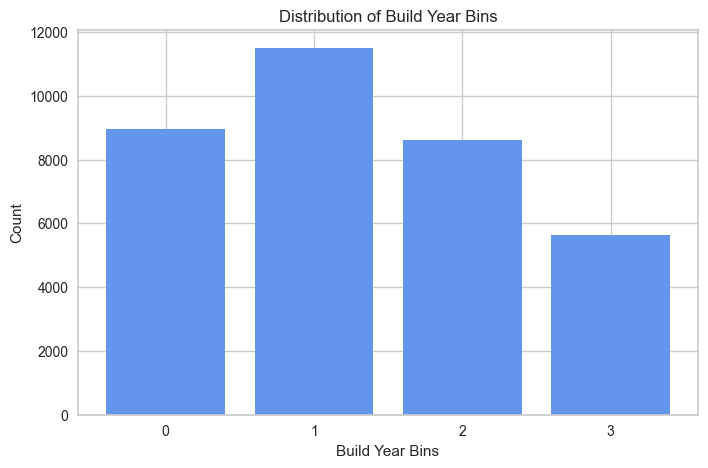

In [174]:
bin_counts = train_map["buildYear_bins"].value_counts().sort_index()

# Create bar plot
plt.figure(figsize=(8, 5))
plt.bar(bin_counts.index, bin_counts.values, color="cornflowerblue")
plt.xlabel("Build Year Bins")
plt.ylabel("Count")
plt.title("Distribution of Build Year Bins")
plt.xticks(bin_counts.index)
plt.show()

In [177]:
# Compute bin edges from training set only
quantiles = pd.qcut(
    train_map["buildingFloorsNum"], q=4, duplicates="drop", retbins=True
)[1]


def buildingFloorsNumBins(df, bins):
    df.loc[:, "buildingFloorsNum_bins"] = (
        pd.cut(
            df["buildingFloorsNum"],
            bins=bins,
            labels=range(1, len(bins)),  # Adjust labels dynamically
            include_lowest=True,
        )
        .astype("category")
        .cat.codes
    )
    return df


train_map = buildingFloorsNumBins(train_map, quantiles)
test_map = buildingFloorsNumBins(test_map, quantiles)

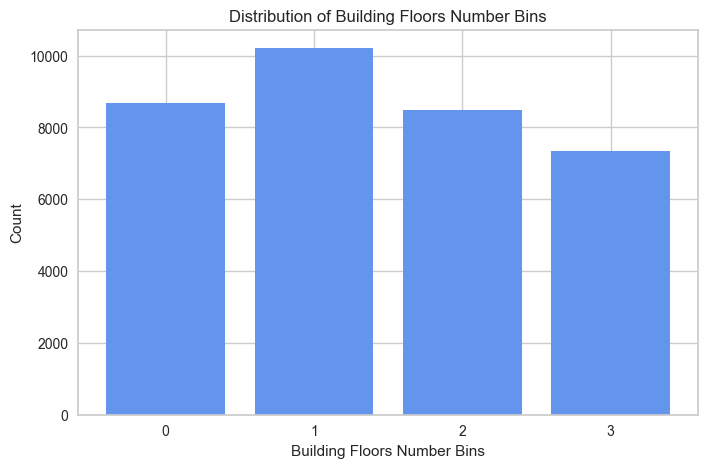

In [178]:
bin_counts = train_map["buildingFloorsNum_bins"].value_counts().sort_index()

# Create bar plot
plt.figure(figsize=(8, 5))
plt.bar(bin_counts.index, bin_counts.values, color="cornflowerblue")
plt.xlabel("Building Floors Number Bins")
plt.ylabel("Count")
plt.title("Distribution of Building Floors Number Bins")
plt.xticks(bin_counts.index)
plt.show()

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5]),
 [Text(0, 0.5, 'areaInSquareMeters'),
  Text(0, 1.5, 'roomsNumber'),
  Text(0, 2.5, 'price'),
  Text(0, 3.5, 'market'),
  Text(0, 4.5, 'advertiserType'),
  Text(0, 5.5, 'advertType'),
  Text(0, 6.5, 'buildYear'),
  Text(0, 7.5, 'buildingFloorsNum'),
  Text(0, 8.5, 'buildingOwnership'),
  Text(0, 9.5, 'latitude'),
  Text(0, 10.5, 'longitude'),
  Text(0, 11.5, 'buildingFloorsNumLog'),
  Text(0, 12.5, 'buildYear_bins'),
  Text(0, 13.5, 'buildingFloorsNum_bins')])

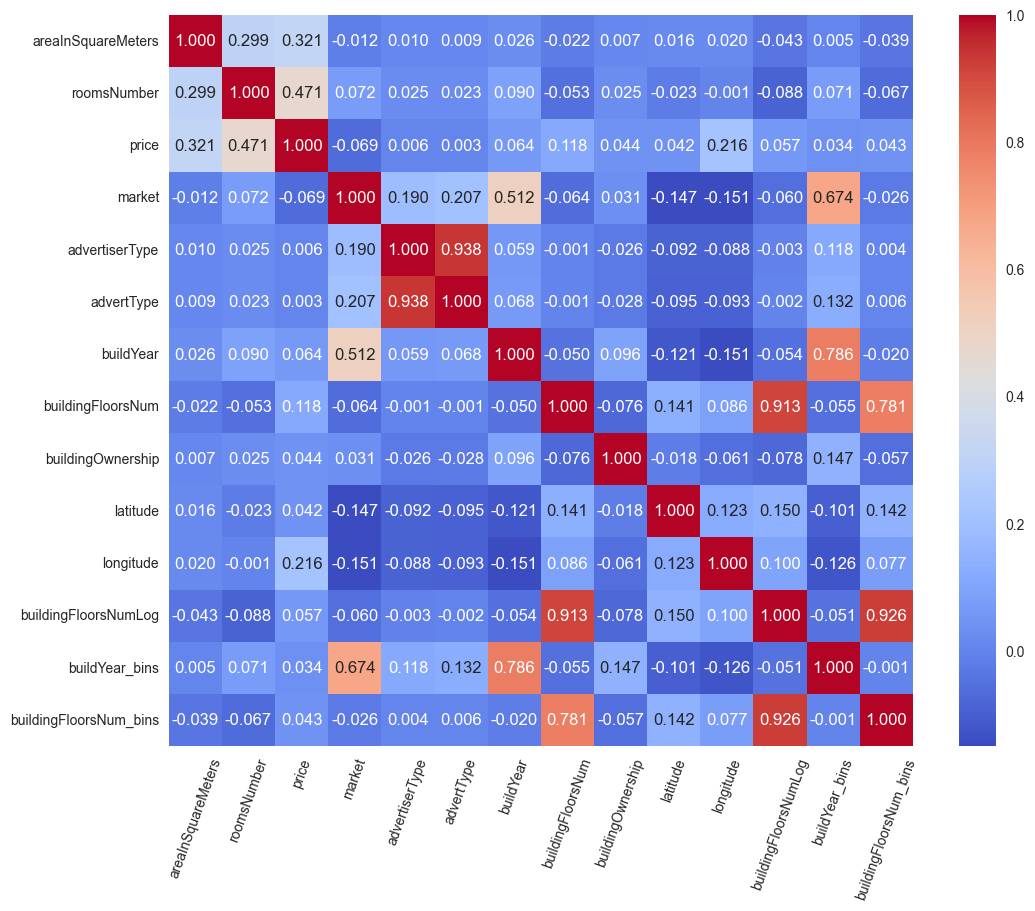

In [38]:
# Correlation Heatmap
plt.figure(figsize=(12, 9.5))
correlations_matrix = train_map.corr(numeric_only=True)
sns.heatmap(correlations_matrix, annot=True, cmap="coolwarm", fmt=".3f")
plt.xticks(rotation=70)
plt.yticks(rotation=0)

**Binning:**

buildYear binning haven't improved correlation

buildingFloorsNum binning haven't improved correlation

**Logarithmic Transformation:**

buildingFloorsNumLog shows worse correlation than base feature.

*New features usability will be dermined by feature importances and BorutaPy.*

## Data Enrichment

Integrating additional external or supplementary data into existing dataset to provide more context or improve model performance. Data from official statistical government website.

In [180]:
def add_population(df):
    """Add average city population."""
    df.insert(loc=len(df.columns), column="population", value=df["city"])
    dict_map = {
        "Wrocław": 670000,
        "Poznań": 540000,
        "Łódź": 655000,
        "Warszawa": 1860000,
        "Kraków": 807600,
    }
    df["population"] = df["population"].map(dict_map)
    return df


def add_salary(df):
    """Add average city salary."""
    df.insert(loc=len(df.columns), column="avgSalary", value=df["city"])
    dict_map = {
        "Wrocław": 8900,
        "Poznań": 7400,
        "Łódź": 8100,
        "Warszawa": 9700,
        "Kraków": 10170,
    }
    df["avgSalary"] = df["avgSalary"].map(dict_map)
    return df


def add_area(df):
    """Add city area."""
    df.insert(
        loc=len(df.columns), column="cityArea", value=df["city"], allow_duplicates=True
    )
    dict_map = {
        "Wrocław": 293,
        "Poznań": 262,
        "Łódź": 293,
        "Warszawa": 517,
        "Kraków": 327,
    }
    df["cityArea"] = df["cityArea"].map(dict_map)
    return df


def add_advanced_features(df):
    """Compute additional city-based metrics."""
    wro_sum = (df["city"] == "Wrocław").sum()
    poz_sum = (df["city"] == "Poznań").sum()
    wwa_sum = (df["city"] == "Warszawa").sum()
    kr_sum = (df["city"] == "Kraków").sum()
    ldz_sum = (df["city"] == "Łódź").sum()

    dict_map_sum = {
        "Wrocław": wro_sum,
        "Poznań": poz_sum,
        "Warszawa": wwa_sum,
        "Kraków": kr_sum,
        "Łódź": ldz_sum,
    }

    """Population-to-Flat Ratio: population/total flats"""
    df.insert(
        loc=len(df.columns),
        column="Population_to_Flat_Ratio",
        value=df["city"],
        allow_duplicates=True,
    )
    df["Population_to_Flat_Ratio"] = df["Population_to_Flat_Ratio"].map(dict_map_sum)
    df["Population_to_Flat_Ratio"] = round(
        df["population"] / df["Population_to_Flat_Ratio"]
    )

    """Flat Availability Rate: total flats / population"""
    df.insert(
        loc=len(df.columns),
        column="Flat_Availability_Rate",
        value=df["city"],
        allow_duplicates=True,
    )
    df["Flat_Availability_Rate"] = df["Flat_Availability_Rate"].map(dict_map_sum)
    df["Flat_Availability_Rate"] = df["Flat_Availability_Rate"] / df["population"]

    """Flats per Income Unit: total flats/average salary"""
    df.insert(
        loc=len(df.columns),
        column="Flats_per_Income_Unit",
        value=df["city"],
        allow_duplicates=True,
    )
    df["Flats_per_Income_Unit"] = df["Flats_per_Income_Unit"].map(dict_map_sum)
    df["Flats_per_Income_Unit"] = round(
        df["Flats_per_Income_Unit"] / df["avgSalary"], 2
    )

    """Housing Density: total flats/city area"""
    df["housingDensity"] = df["city"].map(dict_map_sum) / df["cityArea"]
    return df

In [181]:
def add_features(df):
    """Add population, salary, area, and advanced features."""
    add_population(df)
    add_salary(df)
    add_area(df)
    add_advanced_features(df)
    return df

In [182]:
train_map = add_features(train_map)
test_map = add_features(test_map)

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5, 20.5]),
 [Text(0, 0.5, 'areaInSquareMeters'),
  Text(0, 1.5, 'roomsNumber'),
  Text(0, 2.5, 'price'),
  Text(0, 3.5, 'market'),
  Text(0, 4.5, 'advertiserType'),
  Text(0, 5.5, 'advertType'),
  Text(0, 6.5, 'buildYear'),
  Text(0, 7.5, 'buildingFloorsNum'),
  Text(0, 8.5, 'buildingOwnership'),
  Text(0, 9.5, 'latitude'),
  Text(0, 10.5, 'longitude'),
  Text(0, 11.5, 'buildingFloorsNumLog'),
  Text(0, 12.5, 'buildYear_bins'),
  Text(0, 13.5, 'buildingFloorsNum_bins'),
  Text(0, 14.5, 'population'),
  Text(0, 15.5, 'avgSalary'),
  Text(0, 16.5, 'cityArea'),
  Text(0, 17.5, 'Population_to_Flat_Ratio'),
  Text(0, 18.5, 'Flat_Availability_Rate'),
  Text(0, 19.5, 'Flats_per_Income_Unit'),
  Text(0, 20.5, 'housingDensity')])

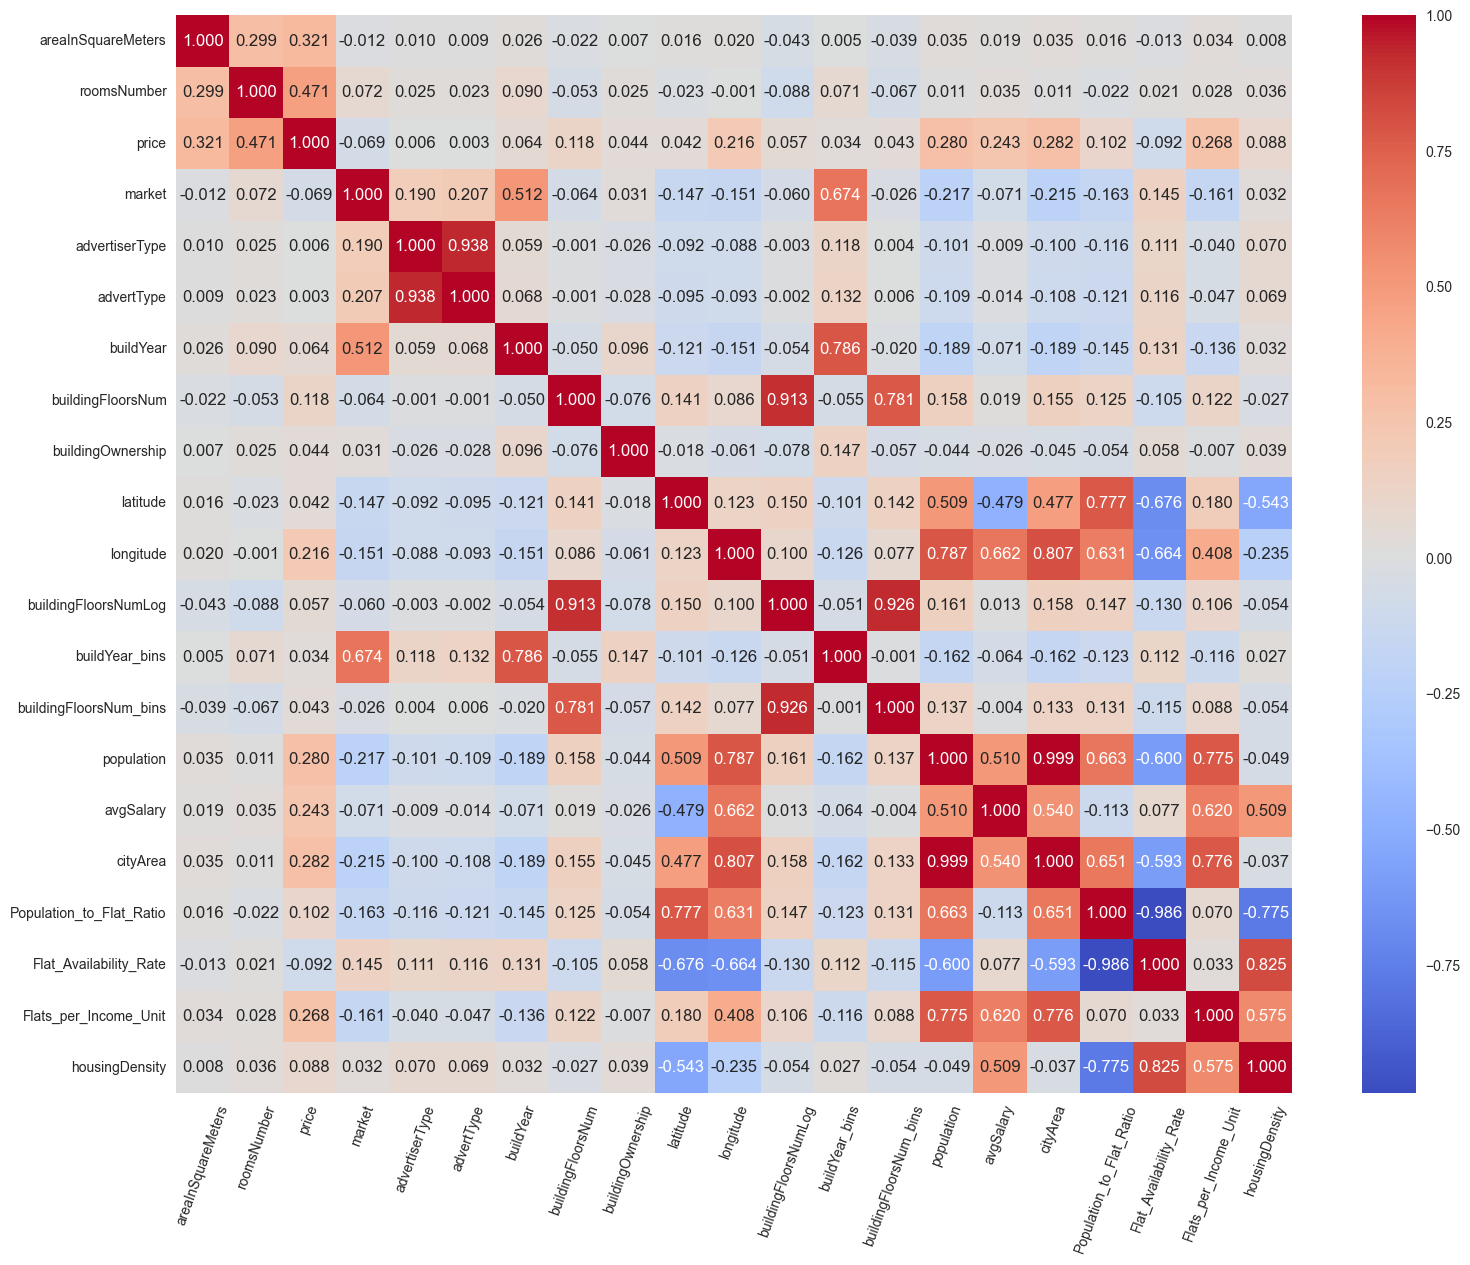

In [42]:
# Correlation Heatmap
plt.figure(figsize=(18, 14))
correlations_matrix = train_map.corr(numeric_only=True)
sns.heatmap(correlations_matrix, annot=True, cmap="coolwarm", fmt=".3f")
plt.xticks(rotation=70)
plt.yticks(rotation=0)

Additional supplementary data shows signifficant correlation with price.

# Feature Selection

## Multicollinearity 

In [ ]:
# Checking multicollinearity for featurees before data enrichment
colums_to_drop = [
    "price",
    "population",
    "avgSalary",
    "cityArea",
    "Population_to_Flat_Ratio",
    "Flat_Availability_Rate",
    "Flats_per_Income_Unit",
    "housingDensity",
]
df_numerics_only = list(
    train_map.drop(columns=colums_to_drop).select_dtypes(include=np.number).columns
)


def calculate_vif(df):
    """Calculate Variance Inflation Factor."""
    vif_data = pd.DataFrame()
    vif_data["feature"] = df.columns
    vif_data["VIF"] = [
        variance_inflation_factor(df.values, i) for i in range(df.shape[1])
    ]
    return vif_data


vif_result = calculate_vif(train_map[df_numerics_only])
print("Variance Inflation Factors:")
print(vif_result)

Variance Inflation Factors:
                   feature          VIF
0       areaInSquareMeters     1.752616
1              roomsNumber     8.596523
2                   market     3.045958
3           advertiserType    78.805524
4               advertType    70.818902
5                buildYear  3102.647556
6        buildingFloorsNum    24.190630
7        buildingOwnership     4.168953
8                 latitude  2988.959674
9                longitude   136.947469
10    buildingFloorsNumLog   339.161294
11          buildYear_bins     5.874458
12  buildingFloorsNum_bins    23.856863


In [ ]:
# Checking multicollinearity for featurees after data enrichment
colums_to_drop = ["price"]
df_numerics_only = list(
    train_map.drop(columns=colums_to_drop).select_dtypes(include=np.number).columns
)


def calculate_vif(df):
    """Calculate Variance Inflation Factor."""
    vif_data = pd.DataFrame()
    vif_data["feature"] = df.columns
    vif_data["VIF"] = [
        variance_inflation_factor(df.values, i) for i in range(df.shape[1])
    ]
    return vif_data


vif_result = calculate_vif(train_map[df_numerics_only])
print("Variance Inflation Factors:")
print(vif_result.round(3))

f:\repository\.venv\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


Variance Inflation Factors:
                     feature       VIF
0         areaInSquareMeters     1.103
1                roomsNumber     1.129
2                     market     1.960
3             advertiserType     8.298
4                 advertType     8.362
5                  buildYear     2.684
6          buildingFloorsNum     7.399
7          buildingOwnership     1.044
8                   latitude   602.859
9                  longitude  1038.413
10      buildingFloorsNumLog    20.733
11            buildYear_bins     3.668
12    buildingFloorsNum_bins     8.825
13                population       inf
14                 avgSalary       inf
15                  cityArea       inf
16  Population_to_Flat_Ratio       inf
17    Flat_Availability_Rate       inf
18     Flats_per_Income_Unit       inf
19            housingDensity       inf


VIF>10 is treated as high multicolinearity. 

Possible actions:

* Ignore 
* Throw out predictors
* Pool predictors
* Structural multicolinearity
* Penalized regression
* Specification errors

## Feature Importances and BorutaPy 

In [183]:
# Based on VIF, Heatmap and Feature importances columns without signifficant influence on performance were chosed to be dropped
# ("district", "subdivision", "city") dropped, they introduce variancy and engage a lot of additional computational resources

colums_to_drop = [
    "price",
    "buildingFloorsNum_bins",
    "buildYear_bins",
    "buildingFloorsNumLog",
    "advertType",
    "advertiserType",
    "buildingOwnership",
    "market",
    "roomsNumber",
    "district",
    "subdivision",
    "city",
]

num_features = list(
    train_map.drop(columns=colums_to_drop).select_dtypes(include=np.number).columns
)
cat_features = list(
    train_map.drop(columns=colums_to_drop).select_dtypes(include=["object"]).columns
)

X_train = train_map.drop(columns=colums_to_drop)
y_train = train_map["price"]

X_test = test_map.drop(columns=colums_to_drop)
y_test = test_map["price"]

preprocessor = ColumnTransformer(
    [
        (
            "num",
            StandardScaler(),
            num_features,
        ),
        (
            "cat",
            OneHotEncoder(handle_unknown="ignore", sparse_output=False),
            cat_features,
        ),
    ]
)

# Fit the preprocessor
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

model = RandomForestRegressor(random_state=SEED)
model.fit(X_train_transformed, y_train)
preds_test = model.predict(X_test_transformed)


# Get feature importances
feature_names = preprocessor.get_feature_names_out()
importance = model.feature_importances_
feature_importance_dict = dict(zip(feature_names, importance))
sorted_importances = sorted(
    zip(feature_names, importance), key=lambda x: x[1], reverse=True
)

print("\nSorted Feature Importances:")
for feature, importance in sorted_importances:
    print(f"{feature}: {importance:.4f}")

# Visualizing feature importances
plt.figure(figsize=(10, 6))
plt.barh(
    [x[0] for x in sorted_importances],
    [x[1] for x in sorted_importances],
    color="cornflowerblue",
)
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.title("Feature Importances in Random Forest")
plt.gca().invert_yaxis()
plt.show()


Sorted Feature Importances:
num__areaInSquareMeters: 0.6283
num__longitude: 0.1345
num__buildingFloorsNum: 0.0694
num__latitude: 0.0661
num__buildYear: 0.0329
cat__buildingType_['block']: 0.0141
cat__buildingType_['apartment']: 0.0068
num__Flats_per_Income_Unit: 0.0052
num__population: 0.0051
num__housingDensity: 0.0047
cat__constructionStatus_['ready_to_use']: 0.0047
num__avgSalary: 0.0047
cat__buildingType_['tenement']: 0.0038
cat__outdoor_None: 0.0033
cat__outdoor_balcony: 0.0030
cat__outdoor_terrace: 0.0028
cat__constructionStatus_['to_completion']: 0.0023
cat__constructionStatus_None: 0.0023
cat__constructionStatus_['to_renovation']: 0.0016
num__Flat_Availability_Rate: 0.0016
num__cityArea: 0.0012
num__Population_to_Flat_Ratio: 0.0011
cat__outdoor_garden: 0.0005


Benefits of PCA are more noticeable when you have multiple correlated features.  

Geospatial data often has non-linear relationships and converting it is generally not advised in most cases. 

Using PCA also causes loss of interpretability, and that's why this method of dimensionality reduction was discarded.

### BorutaPy

In [ ]:
# BorutaPy with regression - on already slightly filtered set by gained insights from feature importances
colums_to_drop = [
    "price",
    "buildingFloorsNum_bins",
    "buildYear_bins",
    "buildingFloorsNumLog",
    "advertType",
    "advertiserType",
    "buildingOwnership",
    "market",
    "district",
    "subdivision",
    "city",
]


num_features = list(
    train_map.drop(columns=colums_to_drop).select_dtypes(include=np.number).columns
)
cat_features = list(
    train_map.drop(columns=colums_to_drop).select_dtypes(include=["object"]).columns
)

X_train = train_map.drop(columns=colums_to_drop)
X_test = test_map.drop(columns=colums_to_drop)

y_train = train_map["price"]
y_test = test_map["price"]

preprocessor = ColumnTransformer(
    [
        (
            "num",
            StandardScaler(),
            num_features,
        ),
        (
            "cat",
            OneHotEncoder(drop="first", handle_unknown="ignore", sparse_output=False),
            cat_features,
        ),
    ]
)
# drop="first" If all categories are kept, one column can be perfectly predicted from the others, leading to redundancy (multicollinearity).Dropping the first category reduces this.

# Fit the preprocessor
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

model = RandomForestRegressor(random_state=SEED)
boruta_selector = BorutaPy(model, n_estimators="auto", verbose=-2, random_state=SEED)
boruta_selector.fit(X_train_transformed, y_train)

# Create DataFrame with feature names, ranking, and selection status
feature_names = preprocessor.get_feature_names_out()
selected_features_df = pd.DataFrame(
    {
        "Feature": feature_names,
        "Ranking": boruta_selector.ranking_,
        "Selected": boruta_selector.support_,
    }
)

# Sort by ranking (1 = most important features)
sorted_features_df = selected_features_df.sort_values(by="Ranking")

print("Selected Features by BorutaPy:")
print(sorted_features_df)

Selected Features by BorutaPy:
                                  Feature  Ranking  Selected
0                 num__areaInSquareMeters        1      True
2                          num__buildYear        1      True
3                  num__buildingFloorsNum        1      True
4                           num__latitude        1      True
5                          num__longitude        1      True
1                        num__roomsNumber        2     False
13                cat__buildingType_block        3     False
7                          num__avgSalary        4     False
6                         num__population        5     False
11             num__Flats_per_Income_Unit        6     False
12                    num__housingDensity        7     False
15   cat__constructionStatus_ready_to_use        8     False
14             cat__buildingType_tenement        9     False
20                   cat__outdoor_terrace       10     False
18                   cat__outdoor_balcony       11    

In [ ]:
# Prepare also BorutaPy for classification by binning, to see the difference in outcome

# Convert regression target into classification bins
kbins = KBinsDiscretizer(n_bins=10, encode="ordinal", strategy="quantile")
y_train_binned = kbins.fit_transform(y_train.values.reshape(-1, 1)).ravel()

# Use BorutaPy with a classifier
model = RandomForestClassifier(random_state=SEED)
boruta_selector = BorutaPy(model, n_estimators="auto", verbose=-2, random_state=SEED)
boruta_selector.fit(X_train_transformed, y_train_binned)

# Create DataFrame with feature names, ranking, and selection status
feature_names = preprocessor.get_feature_names_out()
selected_features_df = pd.DataFrame(
    {
        "Feature": feature_names,
        "Ranking": boruta_selector.ranking_,
        "Selected": boruta_selector.support_,
    }
)

# Sort by ranking (1 = most important features)
sorted_features_df = selected_features_df.sort_values(by="Ranking")

print("Selected Features by BorutaPy:")
print(sorted_features_df)

Selected Features by BorutaPy:
                                  Feature  Ranking  Selected
0                 num__areaInSquareMeters        1      True
2                          num__buildYear        1      True
5                          num__longitude        1      True
4                           num__latitude        1      True
1                        num__roomsNumber        2     False
3                  num__buildingFloorsNum        3     False
13                cat__buildingType_block        4     False
15   cat__constructionStatus_ready_to_use        5     False
7                          num__avgSalary        6     False
18                   cat__outdoor_balcony        7     False
11             num__Flats_per_Income_Unit        8     False
16  cat__constructionStatus_to_completion        9     False
6                         num__population       10     False
12                    num__housingDensity       11     False
9           num__Population_to_Flat_Ratio       12    

BorutaPy in a very short time and relatively short and simple code showed importances of features and gave the means to transform quicly dataset for further model analysis. It's a very good tool features selection.

In [43]:
# Possible sets to work with for further ML analysis, based on:
    # Feature Importances 
    # Variance Inflation Factors
    # and BorutaPy

# Features to drop, to preserve the most important features
colums_to_drop_basic = [
    "roomsNumber",
    "price",
    "market",
    "advertiserType",
    "advertType",
    "buildingFloorsNum",
    "buildingOwnership",
    "buildingType",
    "constructionStatus",
    "outdoor",
    "subdivision",
    "district",
    "city",
    "buildingFloorsNumLog",
    "buildYear_bins",
    "buildingFloorsNum_bins",
    "population",
    "avgSalary",
    "cityArea",
    "Population_to_Flat_Ratio",
    "Flat_Availability_Rate",
    "Flats_per_Income_Unit",
    "housingDensity",
]

# Features to drop, to preserve extended features
colums_to_drop_extended = [
    "price",
    "market",
    "advertiserType",
    "advertType",
    "buildingOwnership",
    "outdoor",
    "subdivision",
    "district",
    "city",
    "buildingFloorsNumLog",
    "buildYear_bins",
    "buildingFloorsNum_bins",
    "cityArea",
    "Population_to_Flat_Ratio",
    "Flat_Availability_Rate",
]

# Multi-ML

In [47]:
# Models for initial multi-model check
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(),
    "Lasso Regression": Lasso(),
    "Polynomial Regression3": Pipeline(
        [("poly", PolynomialFeatures(degree=3)), ("lr", LinearRegression())]
    ),
    "Random Forest": RandomForestRegressor(),
    "SVR": SVR(),
    "LightGBM": LGBMRegressor(verbose=-1),
    "XGBoost": XGBRegressor(),
}

In [45]:
def evaluate_model(models, X_train, y_train, X_test, y_test):
    """Evaluate models on train and test sets."""
    metrics = [MAE, MAPE, rmse, r2_score]
    scores_train = []
    scores_test = []
    plt.figure(figsize=(12, 8))

    for i, (name, model) in enumerate(models.items()):
        model.fit(X_train, y_train)
        preds_train = model.predict(X_train)
        preds_test = model.predict(X_test)

        model_scores_train = {"Model": name}
        model_scores_test = {"Model": name}
        for metric in metrics:
            model_scores_train[metric.__name__] = metric(y_train, preds_train)
            model_scores_test[metric.__name__] = metric(y_test, preds_test)
        scores_train.append(model_scores_train)
        scores_test.append(model_scores_test)

        # Scatter plot for actual vs predicted values
        plt.subplot(4, 3, i + 1)  # Adjusting for more models
        plt.scatter(y_test, preds_test, alpha=0.5, edgecolors="k")
        plt.plot(
            [y_test.min(), y_test.max()],
            [y_test.min(), y_test.max()],
            color="red",
            linestyle="--",
        )
        plt.xlabel("Actual Values")
        plt.ylabel("Predicted Values")
        plt.title(f"{name}: Actual vs Predicted")

    plt.tight_layout()
    plt.show()

    # Convert results to DataFrame and display
    results_df_train = pd.DataFrame(scores_train)
    results_df_test = pd.DataFrame(scores_test)

    print("\n=== Train Metrics ===")
    print(results_df_train.to_string(index=False, float_format="%.4f"))

    print("\n=== Test Metrics ===")
    print(results_df_test.to_string(index=False, float_format="%.4f"))

In [46]:
def preprocessor_multi_ml(num_feat, cat_feat):
    """Create a preprocessor for numerical and categorical features."""
    preprocessor = ColumnTransformer(
        [
            (
                "num",
                StandardScaler(),
                num_feat,
            ),
            (
                "cat",
                OneHotEncoder(handle_unknown="ignore", sparse_output=False),
                cat_feat,
            ),
        ]
    )
    return preprocessor

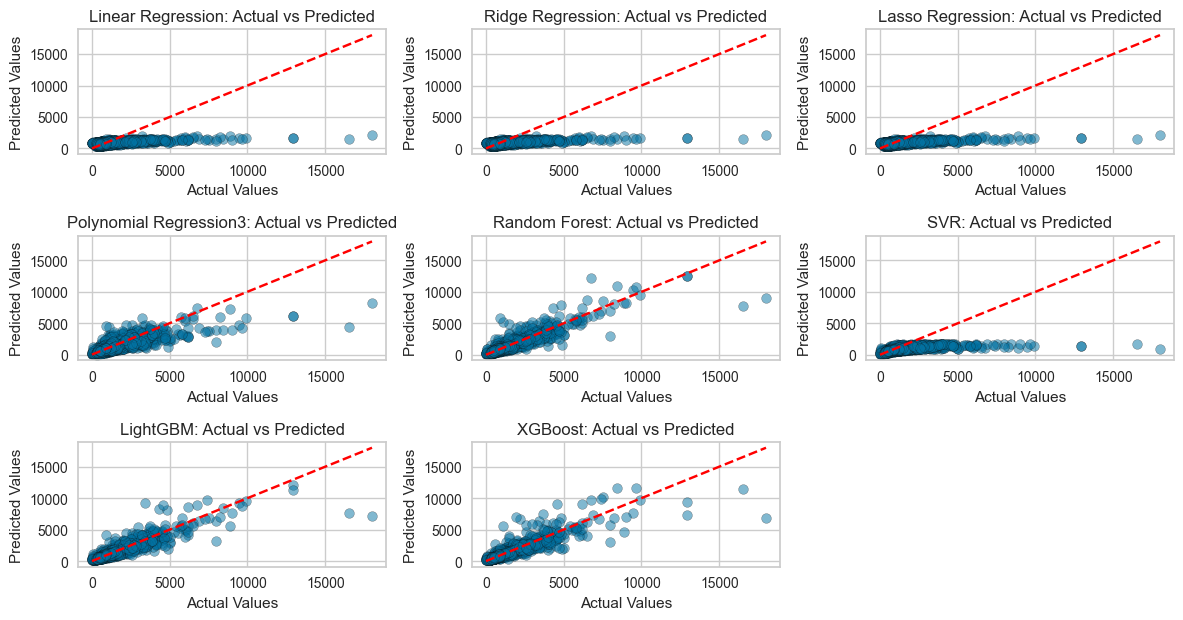


=== Train Metrics ===
                 Model  mean_absolute_error  mean_absolute_percentage_error     rmse  r2_score
     Linear Regression             321.1147                          0.4727 652.9837    0.1551
      Ridge Regression             321.1150                          0.4727 652.9837    0.1551
      Lasso Regression             321.0667                          0.4726 652.9869    0.1551
Polynomial Regression3             192.6202                          0.2477 399.4710    0.6838
         Random Forest              37.8934                          0.0537 107.2169    0.9772
                   SVR             222.9299                          0.2389 589.1825    0.3121
              LightGBM             108.3631                          0.1612 230.8603    0.8944
               XGBoost              85.5846                          0.1320 144.9741    0.9584

=== Test Metrics ===
                 Model  mean_absolute_error  mean_absolute_percentage_error     rmse  r2_score
     

In [48]:
# Testing models performance for basic features - base for comparisons
num_features = list(
    train_map.drop(columns=colums_to_drop_basic)
    .select_dtypes(include=np.number)
    .columns
)
cat_features = list(
    train_map.drop(columns=colums_to_drop_basic)
    .select_dtypes(include=["object"])
    .columns
)

X_train = train_map.drop(columns=colums_to_drop_basic)
X_test = test_map.drop(columns=colums_to_drop_basic)

y_train = train_map["price"]
y_test = test_map["price"]

preprocessor_ml = preprocessor_multi_ml(num_features, cat_features)

X_train_transformed = preprocessor_ml.fit_transform(X_train)
X_test_transformed = preprocessor_ml.transform(X_test)
evaluate_model(models, X_train_transformed, y_train, X_test_transformed, y_test)

The scatter of predictions vs. true prices shows points mostly aligned along the diagonal, indicating the model captures much of the price variation. However, at lower price ranges the spread is wider – the model struggles relatively more with inexpensive apartments. This is heteroscedastic pattern, variance is unequal over the range of measured values. 

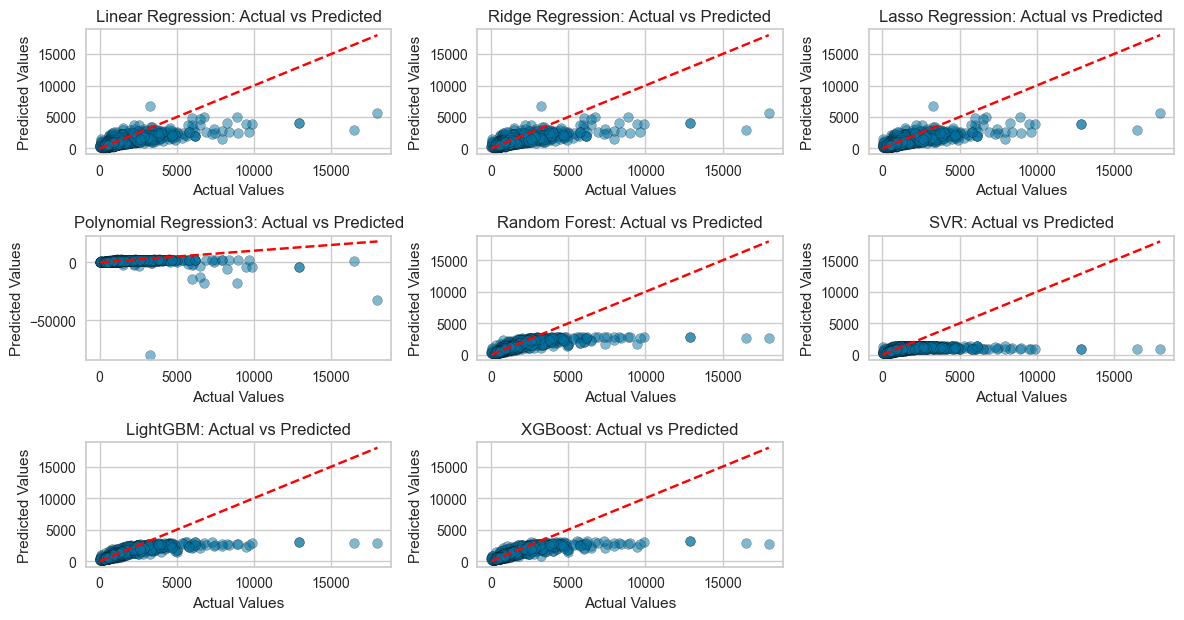


=== Train Metrics ===
                 Model  mean_absolute_error  mean_absolute_percentage_error     rmse  r2_score
     Linear Regression             189.7259                          0.2459 271.8214    0.5711
      Ridge Regression             189.7250                          0.2459 271.8214    0.5711
      Lasso Regression             189.5090                          0.2455 271.8293    0.5710
Polynomial Regression3             148.8079                          0.1709 226.4898    0.7022
         Random Forest              30.1173                          0.0347  53.4701    0.9834
                   SVR             164.4290                          0.1741 277.0163    0.5545
              LightGBM              88.5093                          0.1045 138.1448    0.8892
               XGBoost              73.9845                          0.0886 114.2687    0.9242

=== Test Metrics ===
                 Model  mean_absolute_error  mean_absolute_percentage_error      rmse  r2_score
    

In [49]:
# Testing models performance for basic features - removing 1 percentile of outliers on training set
train_out_map_add_quan = train_map.copy()


def remove_outl(df):
    """Remove 1st and 99th percentile outliers."""
    q_lower = 0.01
    q_higher = 0.99
    df = df[
        (df["areaInSquareMeters"] <= df["areaInSquareMeters"].quantile(q_higher))
        & (df["areaInSquareMeters"] >= df["areaInSquareMeters"].quantile(q_lower))
    ]
    df = df[
        (df["price"] <= df["price"].quantile(q_higher))
        & (df["price"] >= df["price"].quantile(q_lower))
    ]
    return df


train_out_map_add_quan = remove_outl(train_out_map_add_quan)


num_features = list(
    train_out_map_add_quan.drop(columns=colums_to_drop_basic)
    .select_dtypes(include=np.number)
    .columns
)
cat_features = list(
    train_out_map_add_quan.drop(columns=colums_to_drop_basic)
    .select_dtypes(include=["object"])
    .columns
)

X_train = train_out_map_add_quan.drop(columns=colums_to_drop_basic)
X_test = test_map.drop(columns=colums_to_drop_basic)

y_train = train_out_map_add_quan["price"]
y_test = test_map["price"]

preprocessor_ml = preprocessor_multi_ml(num_features, cat_features)

X_train_transformed = preprocessor_ml.fit_transform(X_train)
X_test_transformed = preprocessor_ml.transform(X_test)
evaluate_model(models, X_train_transformed, y_train, X_test_transformed, y_test)

Removing outliers on train set improves simple linear models performance, but impare tree-based models. Based on that analysis it's visible, that removing outliers isn't good for pursuing the best models performance. It requires additional step in data preparation and isn't providing sufficient leverage.

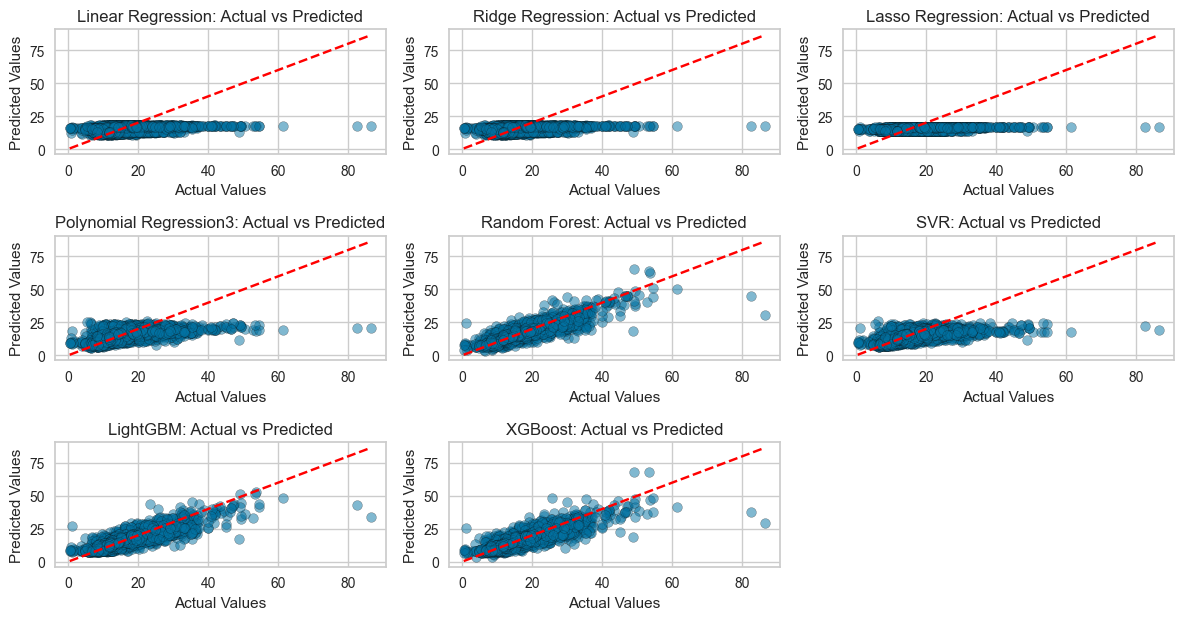


=== Train Metrics ===
                 Model  mean_absolute_error  mean_absolute_percentage_error   rmse  r2_score
     Linear Regression               3.5945                          0.3135 5.0711    0.1487
      Ridge Regression               3.5945                          0.3135 5.0711    0.1487
      Lasso Regression               3.6767                          0.3216 5.1910    0.1080
Polynomial Regression3               2.8621                          0.2332 4.2706    0.3963
         Random Forest               0.5288                          0.0535 0.9121    0.9725
                   SVR               2.6429                          0.2148 4.2233    0.4095
              LightGBM               1.6406                          0.1611 2.4787    0.7966
               XGBoost               1.3869                          0.1313 2.0769    0.8572

=== Test Metrics ===
                 Model  mean_absolute_error  mean_absolute_percentage_error   rmse  r2_score
     Linear Regression   

In [50]:
# Testing models performance for basic features - changing labels to price per square meter
colums_to_drop_basic_priceM2 = colums_to_drop_basic.copy()
colums_to_drop_basic_priceM2.append("priceM2")


def price_to_M2(df):
    """Convert price to price per square meter."""
    df["priceM2"] = df["price"] / df["areaInSquareMeters"]
    return df


train_map = price_to_M2(train_map)
test_map = price_to_M2(test_map)


num_features = list(
    train_map.drop(columns=colums_to_drop_basic_priceM2)
    .select_dtypes(include=np.number)
    .columns
)
cat_features = list(
    train_map.drop(columns=colums_to_drop_basic_priceM2)
    .select_dtypes(include=["object"])
    .columns
)

X_train = train_map.drop(columns=colums_to_drop_basic_priceM2)
X_test = test_map.drop(columns=colums_to_drop_basic_priceM2)

y_train = train_map["priceM2"]
y_test = test_map["priceM2"]

preprocessor_ml = preprocessor_multi_ml(num_features, cat_features)

X_train_transformed = preprocessor_ml.fit_transform(X_train)
X_test_transformed = preprocessor_ml.transform(X_test)
evaluate_model(models, X_train_transformed, y_train, X_test_transformed, y_test)

In [51]:
# Testing models performance for extended features - with labels price per square meter
colums_to_drop_extended_priceM2 = colums_to_drop_extended.copy()
colums_to_drop_extended_priceM2.append("priceM2")

num_features = list(
    train_map.drop(columns=colums_to_drop_extended_priceM2)
    .select_dtypes(include=np.number)
    .columns
)
cat_features = list(
    train_map.drop(columns=colums_to_drop_extended_priceM2)
    .select_dtypes(include=["object"])
    .columns
)

X_train = train_map.drop(columns=colums_to_drop_extended_priceM2)
X_test = test_map.drop(columns=colums_to_drop_extended_priceM2)

y_train = train_map["priceM2"]
y_test = test_map["priceM2"]

preprocessor_ml = preprocessor_multi_ml(num_features, cat_features)

X_train_transformed = preprocessor_ml.fit_transform(X_train)
X_test_transformed = preprocessor_ml.transform(X_test)
evaluate_model(models, X_train_transformed, y_train, X_test_transformed, y_test)


=== Train Metrics ===
                 Model  mean_absolute_error  mean_absolute_percentage_error   rmse  r2_score
     Linear Regression               2.7475                          0.2412 4.0153    0.4663
      Ridge Regression               2.7501                          0.2414 4.0172    0.4658
      Lasso Regression               3.2996                          0.2844 4.7070    0.2665
Polynomial Regression3               1.9637                          0.1694 2.9814    0.7057
         Random Forest               0.5014                          0.0496 0.8607    0.9755
                   SVR               2.2091                          0.1850 3.6320    0.5633
              LightGBM               1.5382                          0.1520 2.3038    0.8243
               XGBoost               1.2835                          0.1258 1.9203    0.8779

=== Test Metrics ===
                 Model  mean_absolute_error  mean_absolute_percentage_error        rmse         r2_score
     Linear R

**Best outcome: extended features - Random Forest, XGB, LGBM. Labels: price per square meter.**

MAPE results for analysis price per square meter are better that MAPE for flat price. By predicting on a per-square-meter basis, the model handles small and large apartments more consistently.

Linear Models had the highest bias and lowest variance. It underfits the data: the training and test R² were both relatively low (the model fails to capture complex location and quality effects), but importantly the train–test gap was small. This indicates the linear model is too rigid (high bias) but generalizes consistently (no overfitting).

Tree-Based Models (e.g. Decision Tree, Random Forest) – low bias but very high variance (overfitting the training data). 

***Random Forest***

High but manageable generalization gap in R².

Low MAE in both train and test, making it one of the best performers.

Conclusion: Random Forest provides a strong balance between bias and variance, making it a top contender.


***XGBoost***

Slightly better generalization than Random Forest.

Low MAE, very close to Random Forest.

Conclusion: XGBoost generalizes better than Random Forest. Slightly lower performance.

# Hyperparameters Tuning

In [67]:
def evaluate_model(y_train, y_test, preds_train, preds_test):
    """Evaluate model performance."""
    metrics = [MAE, MAPE, rmse, r2_score]
    scores_train = []
    scores_test = []
    
    # Compute performance metrics for the training set
    model_scores_train = {}
    model_scores_test = {}
    
    plt.figure(figsize=(12, 8))

    # Train & Test set performance metrics
    for metric in metrics:
        model_scores_train[metric.__name__] = metric(y_train, preds_train)  # Calculate metric for train set
    scores_train.append(model_scores_train)
    for metric in metrics:
        model_scores_test[metric.__name__] = metric(y_test, preds_test)  # Calculate metric for test set
    scores_test.append(model_scores_test)

    results_df_train = pd.DataFrame(scores_train)
    results_df_test = pd.DataFrame(scores_test)

    print("\n=== Train Metrics ===")
    print(results_df_train.to_string(index=False, float_format="%.4f"))

    print("\n=== Test Metrics ===")
    print(results_df_test.to_string(index=False, float_format="%.4f"))


    # Scatter plot for actual vs predicted values
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, preds_test, alpha=0.5, edgecolors="k")
    plt.plot(
        [y_test.min(), y_test.max()],
        [y_test.min(), y_test.max()],
        color="red",
        linestyle="--",
    )
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.title("Actual vs Predicted")

    plt.tight_layout()
    plt.show()


In [68]:
def data_for_tuning(train_map, test_map, with_validation):
    """Prepare data for hyperparameter tuning."""
    if not isinstance(with_validation, bool):
        raise TypeError(f"Expected 'variable' to be a boolean, but got {type(with_validation).__name__}")
    
    train_map = train_map.copy()
    test_map = test_map.copy()
    
    colums_to_drop_extended = [
        "price",
        "market",
        "advertiserType",
        "advertType",
        "buildingOwnership",
        "outdoor",
        "subdivision",
        "district",
        "city",
        "buildingFloorsNumLog",
        "buildYear_bins",
        "buildingFloorsNum_bins",
        "cityArea",
        "Population_to_Flat_Ratio",
        "Flat_Availability_Rate",
        "priceM2"
    ]

    num_features = list(
        train_map.drop(columns=colums_to_drop_extended)
        .select_dtypes(include=np.number)
        .columns
    )

    cat_features = list(
        train_map.drop(columns=colums_to_drop_extended)
        .select_dtypes(include=["object"])
        .columns
    )
    
    # Define preprocessing pipeline
    preprocessor = ColumnTransformer(
        [
            (
                "num",
                StandardScaler(),
                num_features,
            ),
            (
                "cat",
                OneHotEncoder(
                    handle_unknown="ignore", sparse_output=False
                ),
                cat_features,
            ),
        ]
    )
    
    X_val_transformed = None
    y_val = None
    
    if with_validation:
        # Create validation test for early stopping
        train, validation = split(stratify(train_map))
        train_map = train_map.drop(
            columns=[
                "stratified",
                "price_cat",
                "areaInSquareMeters_cat",
                "buildYear_cat",
            ]
        )
        # Define feature matrices for train, validation, and test sets
        X_train = train.drop(columns=colums_to_drop_extended)
        X_val = validation.drop(columns=colums_to_drop_extended)
        X_test = test_map.drop(columns=colums_to_drop_extended)
        # Define target variables
        y_train = train["priceM2"]
        y_val = validation["priceM2"]
        y_test = test_map["priceM2"]

        # Fit and transform training data
        X_train_transformed = pd.DataFrame(preprocessor.fit_transform(X_train), columns=preprocessor.get_feature_names_out())  
        X_val_transformed = pd.DataFrame(preprocessor.transform(X_val), columns=preprocessor.get_feature_names_out())  
        X_test_transformed = pd.DataFrame(preprocessor.transform(X_test), columns=preprocessor.get_feature_names_out())  

    else:
        X_train = train_map.drop(columns=colums_to_drop_extended)
        X_test = test_map.drop(columns=colums_to_drop_extended)
        y_train = train_map["priceM2"]
        y_test = test_map["priceM2"]
        
        X_train_transformed = pd.DataFrame(preprocessor.fit_transform(X_train), columns=preprocessor.get_feature_names_out())  
        X_test_transformed = pd.DataFrame(preprocessor.transform(X_test), columns=preprocessor.get_feature_names_out())  

    return X_train_transformed, X_val_transformed, X_test_transformed, y_train, y_val, y_test
    
    

## XGB - extended features, priceM2

In [ ]:
def model_tuning_XGB(model, param_grid, model_name, nIter, X_train_transformed, X_val_transformed, X_test_transformed, y_train, y_val, y_test):
    """Perform hyperparameter tuning, train model, and evaluate performance."""
    # Define cross-validation strategy
    folds = KFold(n_splits=5, shuffle=True, random_state=SEED)

    # Perform hyperparameter tuning using RandomizedSearchCV
    GS = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_grid,
        n_iter=nIter,
        scoring="neg_root_mean_squared_error",
        cv=folds,
        return_train_score=True,
        verbose=1,
        n_jobs=-1,
        refit=True,
        random_state=SEED,
    )

    # Fit model on training data
    GS.fit(X_train_transformed, y_train)
    best_params = GS.best_params_

    # Initialize the best model with optimized hyperparameters
    best_model = XGBRegressor(
        **best_params,
        booster="gbtree",
        tree_method="hist",
        grow_policy="depthwise",
        sampling_method="uniform",
        eval_metric=["rmse"],
        early_stopping_rounds=10,
        verbosity=1,
        random_state=SEED,
    )

    # Train model with early stopping
    best_model.fit(
        X_train_transformed,
        y_train,
        eval_set=[(X_train_transformed, y_train), (X_val_transformed, y_val)],  # Validation monitoring
        verbose=0,
    )

    # Generate predictions
    preds_train = best_model.predict(X_train_transformed)
    preds_test = best_model.predict(X_test_transformed)

    # Save the trained model for future use
    folder_path = "../models/"  # Path to save the model
    filename = f"{model_name}.sav"  # Define filename based on model name
    pickle.dump(best_model, open(f"{folder_path}{filename}", "wb"))  # Save model using pickle

    # Print best hyperparameters found
    print(f"\nBest Parameters: {best_params}")
    
    # Extract and plot training vs validation loss
    results = best_model.evals_result()
    plt.figure(figsize=(10, 6))
    plt.plot(results["validation_0"]["rmse"], label="Training loss")
    plt.plot(results["validation_1"]["rmse"], label="Validation loss")
    plt.xlabel("Number of trees")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Training vs Validation Loss")
    plt.legend()
    
    return preds_train, preds_test


Fitting 5 folds for each of 100 candidates, totalling 500 fits

Best Parameters: {'subsample': 0.7, 'reg_lambda': 5, 'reg_alpha': 1, 'n_estimators': 400, 'min_child_weight': 3, 'max_depth': 9, 'learning_rate': 0.03, 'gamma': 0.1, 'colsample_bytree': 1.0}

=== Train Metrics ===
 mean_absolute_error  mean_absolute_percentage_error   rmse  r2_score
              1.1313                          0.1209 1.7201    0.9001

=== Test Metrics ===
 mean_absolute_error  mean_absolute_percentage_error   rmse  r2_score
              1.4567                          0.1033 2.3193    0.8299


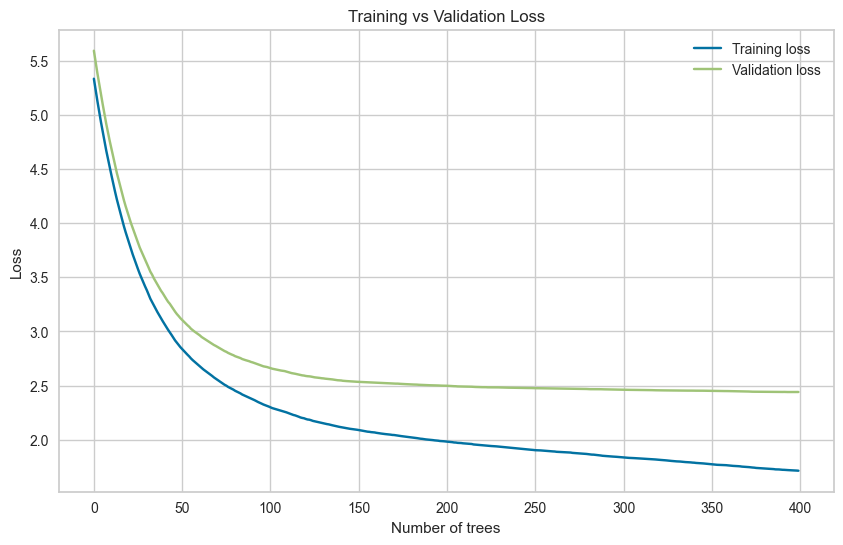

<Figure size 1200x800 with 0 Axes>

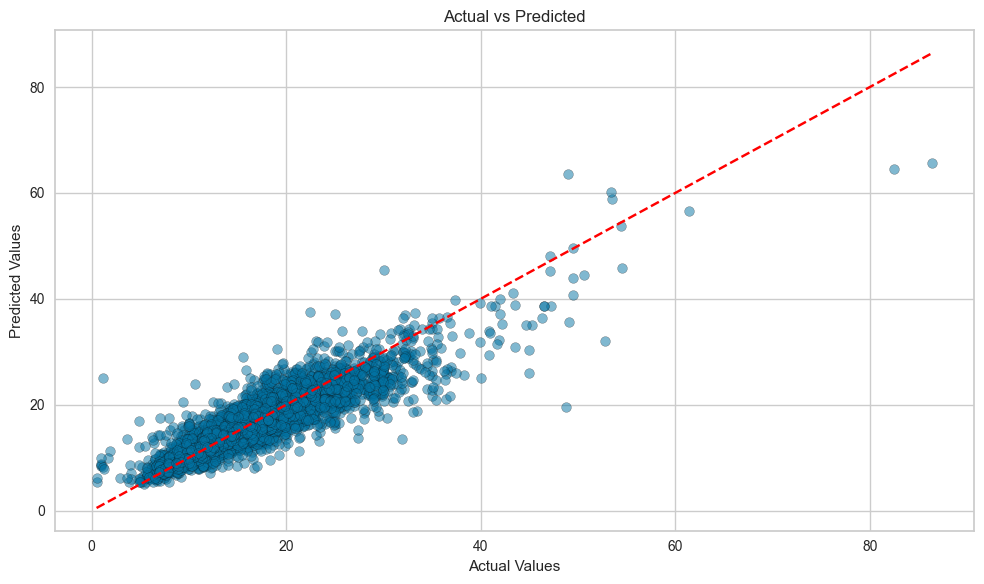

Search took 94.95 seconds.


In [ ]:
X_train_transformed, X_val_transformed, X_test_transformed, y_train, y_val, y_test = (
    data_for_tuning(train_map, test_map, with_validation=True)
)

# Initialize XGBoost Regressor with base parameters
model = XGBRegressor(
    booster="gbtree",  # Gradient-boosted trees for structured data
    tree_method="hist",  # Histogram-based split for efficiency
    grow_policy="depthwise",  # Expand nodes level-wise
    sampling_method="uniform",  # Uniform data sampling
    verbosity=1,  # Display warnings/errors
    random_state=SEED,  # Ensures reproducibility
)

model_name = "XGB"  # Model name for logging

# Start timing to measure training duration
start = time.time()

# Define hyperparameter search space
param_grid = {
    "n_estimators": [200, 300, 400],  # Number of boosting rounds
    "learning_rate": [0.01, 0.03],  # Step size shrinkage to prevent overfitting
    "max_depth": [6, 9],  # Tree depth to control model complexity
    "min_child_weight": [3, 5, 7],  # Minimum sum of instance weight needed in a child
    "subsample": [0.6, 0.7],  # Fraction of data used per boosting iteration
    "colsample_bytree": [0.8, 1.0],  # Fraction of features used per tree
    "gamma": [0, 0.1, 0.3],  # Minimum loss reduction required for a split
    "reg_alpha": [0, 0.1, 0.5, 1],  # L1 regularization (feature selection)
    "reg_lambda": [1, 5, 10],  # L2 regularization (prevents overfitting)
}

nIter = 100  # Number of hyperparameter configurations tested in RandomizedSearchCV

# Run hyperparameter tuning
preds_train_XGB, preds_test_XGB = model_tuning_XGB(
    model,
    param_grid,
    model_name,
    nIter,
    X_train_transformed,
    X_val_transformed,
    X_test_transformed,
    y_train,
    y_val,
    y_test,
)

# Evaluate model performance
evaluate_model(y_train, y_test, preds_train_XGB, preds_test_XGB)

# Print total training time
print("Search took %.2f seconds." % ((time.time() - start)))

## Random Forest - extended features, priceM2

In [ ]:
# Function for hyperparameter tuning, model training, evaluation, and visualization
def model_tuning_RF(model, param_grid, model_name, nIter, X_train_transformed, X_test_transformed, y_train, y_test):
    """Perform hyperparameter tuning and train a Random Forest model."""
    
    # Define cross-validation strategy
    folds = KFold(n_splits=5, shuffle=True, random_state=SEED)

    # Perform hyperparameter tuning using RandomizedSearchCV
    GS = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_grid,
        n_iter=nIter,
        scoring="neg_root_mean_squared_error",
        cv=folds,
        return_train_score=True,
        verbose=1,
        n_jobs=-1,
        refit=True,
        random_state=SEED,
    )

    # Fit model on training data
    GS.fit(X_train_transformed, y_train)
    best_params = GS.best_params_

    # Initialize best model with optimized hyperparameters
    best_model = RandomForestRegressor(
        **best_params,
        random_state=SEED,
        n_jobs=-1,
    )

    # Train the model with best-found parameters
    best_model.fit(
        X_train_transformed,
        y_train,

    )

    # Generate predictions
    preds_train = best_model.predict(X_train_transformed)
    preds_test = best_model.predict(X_test_transformed)

    # Save the trained model for future use
    folder_path = "../models/"  # Path to save the model
    filename = f"{model_name}.sav"  # Define filename based on model name
    pickle.dump(best_model, open(f"{folder_path}{filename}", "wb"))  # Save model using pickle

    # Print best hyperparameters found
    print(f"\nBest Parameters: {best_params}")
    
    return preds_train, preds_test


In [56]:
X_train_transformed, X_val_transformed, X_test_transformed, y_train, y_val, y_test = (
    data_for_tuning(train_map, test_map, with_validation=False)
)

# Initialize Random Forest Regressor
model = RandomForestRegressor(
    bootstrap=True,  # Enables bagging for better generalization
    oob_score=False,  # Disables out-of-bag scoring for efficiency
    warm_start=False,  # Avoids unnecessary memory usage
    ccp_alpha=0.0,  # No aggressive pruning
    criterion="squared_error",  # Standard MSE loss function
    random_state=SEED,
    n_jobs=-1,
)

model_name = "RF"  # Model name for logging

# Start timing to measure training duration
start = time.time()

max_features = X_train_transformed.shape[1]

# Define hyperparameter search space
param_grid = {
    "n_estimators": [800, 1000],  # Number of trees in the forest
    "max_depth": [15, 20, 25],  # Maximum depth of each tree
    "min_samples_split": [10, 15],  # Minimum samples needed to split a node
    "min_samples_leaf": [2, 5],  # Minimum samples required in leaf nodes
    "max_features": [max_features],  # Number of features considered per split
    "bootstrap": [True],  # Use bootstrap sampling
    "max_samples": [0.6, 0.8],  # Fraction of training data used per tree
    "min_impurity_decrease": [0.0005, 0.001],  # Minimum impurity decrease to split
    "max_leaf_nodes": [None, 50],  # Maximum leaf nodes per tree
}


nIter = 50  # Number of hyperparameter configurations tested in RandomizedSearchCV

# Run hyperparameter tuning
preds_train_RF, preds_test_RF = model_tuning_RF(
    model, 
    param_grid, 
    model_name, 
    nIter, 
    X_train_transformed, 
    X_test_transformed, 
    y_train, 
    y_test
)

# Evaluate model performance
evaluate_model(y_train, y_test, preds_train_RF, preds_test_RF)

# Print total training time
print("Search took %.2f seconds." % ((time.time() - start)))

Fitting 5 folds for each of 50 candidates, totalling 250 fits

Best Parameters: {'n_estimators': 1000, 'min_samples_split': 10, 'min_samples_leaf': 2, 'min_impurity_decrease': 0.0005, 'max_samples': 0.8, 'max_leaf_nodes': None, 'max_features': 17, 'max_depth': 25, 'bootstrap': True}

=== Train Metrics ===
 mean_absolute_error  mean_absolute_percentage_error   rmse  r2_score
              1.0541                          0.1074 1.6701    0.9077

=== Test Metrics ===
 mean_absolute_error  mean_absolute_percentage_error   rmse  r2_score
              1.4160                          0.1005 2.2781    0.8359


<Figure size 1200x800 with 0 Axes>

Search took 1087.83 seconds.


Tunned Random Forest have slightly worse metrics for test set than untunned model, but an overfitting is restricted. 

Random forest outperforms XGBoost model.

# NN - extended features, priceM2

Dying ReLu issue was observed for this dataset analysis, different activation aproach checked - swish showed best performance.

In [57]:
def plot_history(history):
    """Plot training history for MAPE and loss."""
    print(history.history.keys())
    print()
    # Plot Mean Absolute Percentage Error (MAPE)
    plt.plot(history.history["mape"])
    plt.plot(history.history["val_mape"])
    plt.title("model MAPE")
    plt.ylabel("MAPE")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()
    # Plot loss
    plt.plot(history.history["loss"])
    plt.plot(history.history["val_loss"])
    plt.title("model loss")
    plt.ylabel("loss")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()


Epoch 22: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 33: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Epoch 38: early stopping
Restoring model weights from the end of the best epoch: 23.
868/868 ━━━━━━━━━━━━━━━━━━━━ 1s 812us/step
272/272 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
272/272 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 21.9302 - mae: 3.0614 - mape: 18.4632
dict_keys(['loss', 'mae', 'mape', 'val_loss', 'val_mae', 'val_mape', 'learning_rate'])

dict_keys(['loss', 'mae', 'mape', 'val_loss', 'val_mae', 'val_mape', 'learning_rate'])



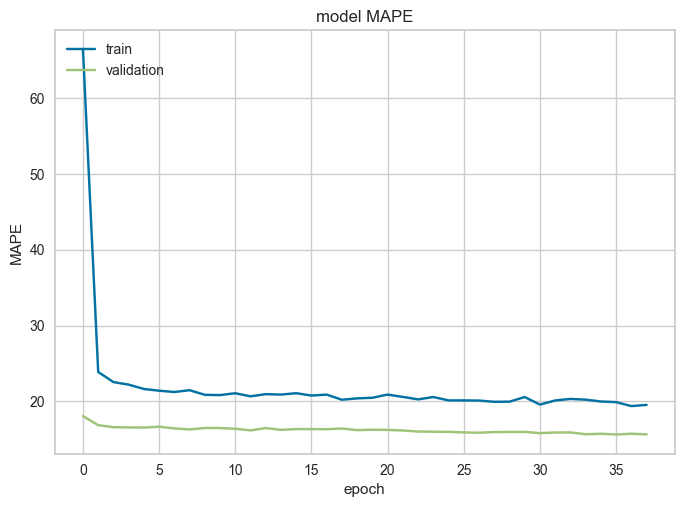

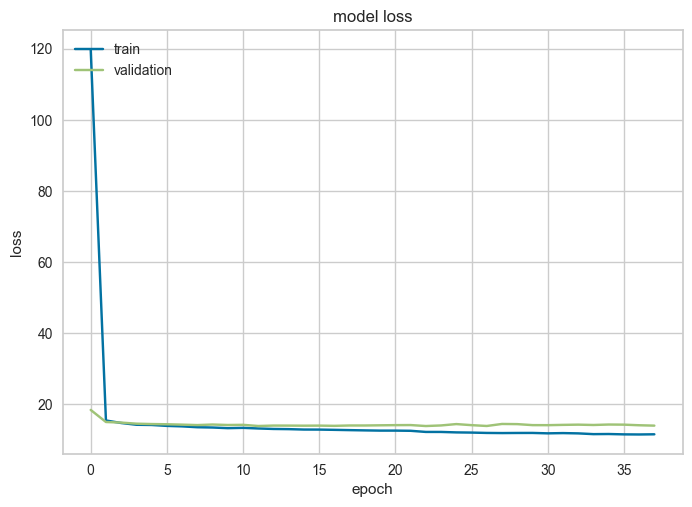


=== Train Metrics ===
 mean_absolute_error  mean_absolute_percentage_error   rmse  r2_score
              2.2233                          0.1955 3.3760    0.6153

=== Test Metrics ===
 mean_absolute_error  mean_absolute_percentage_error   rmse  r2_score
              3.0066                          0.1865 4.5223    0.3534


<Figure size 1200x800 with 0 Axes>

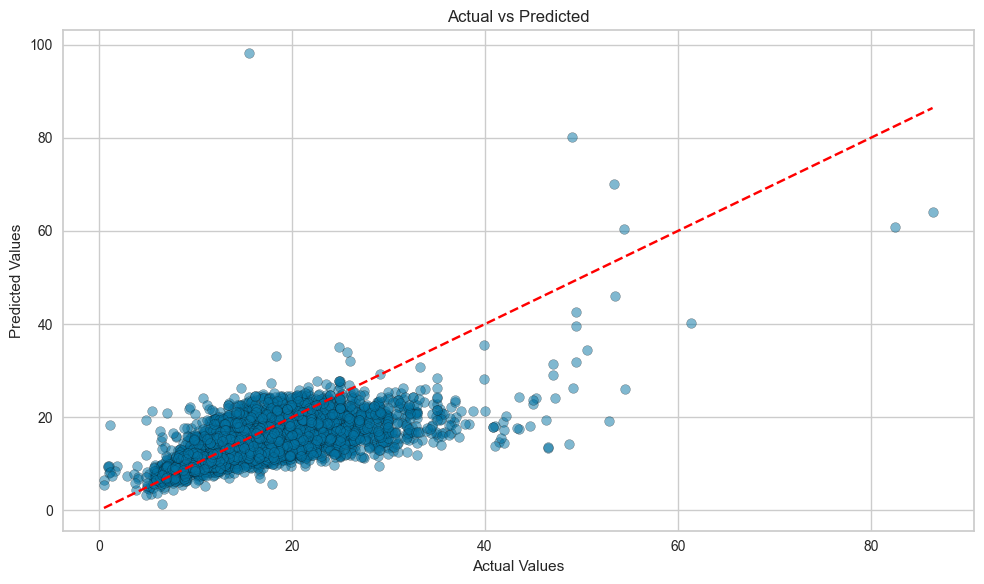

In [ ]:
X_train_transformed, X_val_transformed, X_test_transformed, y_train, y_val, y_test = [
    x.to_numpy() if x is not None else None
    for x in data_for_tuning(train_map, test_map, with_validation=True)
]

# Define model architecture
input_dim = X_train_transformed.shape[1]

model = tf.keras.Sequential(
    [
        Input(shape=(input_dim,)),
        tf.keras.layers.Dense(256),
        tf.keras.layers.Activation(tf.keras.activations.swish),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Dense(128, kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        tf.keras.layers.Activation(tf.keras.activations.swish),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Dense(64, kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        tf.keras.layers.Activation(tf.keras.activations.swish),
        tf.keras.layers.BatchNormalization(),
        
        tf.keras.layers.Dense(1),
    ]
)

# Compile model with AdamW optimizer
optimizer = tf.keras.optimizers.AdamW(learning_rate=0.0005, weight_decay=1e-5)
model.compile(optimizer=optimizer, metrics=["mae", "mape"], loss="mse")

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(
    monitor="val_loss", verbose=1, patience=15, restore_best_weights=True
)

# Learning rate scheduler
lr_scheduler = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=10, verbose=1)

# Train model
history = model.fit(
    X_train_transformed,
    y_train,
    validation_data=(X_val_transformed, y_val),
    batch_size=32,
    epochs=100,
    verbose=0,
    callbacks=[early_stopping, lr_scheduler],
)

# Generate predictions
preds_train = model.predict(X_train_transformed)
preds_test = model.predict(X_test_transformed)

# Evaluate model on test set
model.evaluate(X_test_transformed, y_test)

model.save("../models/NNmodel.h5")

# Plotting models MAPE and los during training
df_history = pd.DataFrame(history.history)

# list all data in history
print(history.history.keys())
print()

# Plot training history
plot_history(history)

# Evaluate predictions
evaluate_model(y_train, y_test, preds_train, preds_test)

# Ensemble 

## Weighted Averaging 


=== Train Metrics ===
 mean_absolute_error  mean_absolute_percentage_error   rmse  r2_score
              1.1291                          0.1218 1.7532    0.8962

=== Test Metrics ===
 mean_absolute_error  mean_absolute_percentage_error   rmse  r2_score
              1.4278                          0.1009 2.2752    0.8363


<Figure size 1200x800 with 0 Axes>

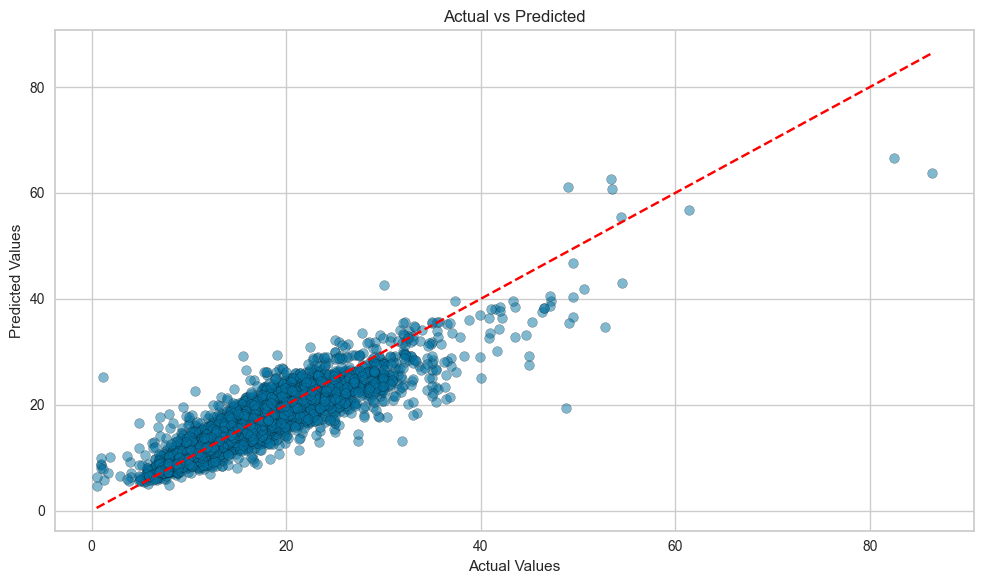

In [ ]:
# Load saved models
XGB_model = joblib.load("../models/XGB.sav")
RF_model = joblib.load("../models/RF.sav")

# Get predictions
xgb_preds_train = XGB_model.predict(X_train_transformed)
rf_preds_train = RF_model.predict(X_train_transformed)

# Get predictions
xgb_preds_test = XGB_model.predict(X_test_transformed)
rf_preds_test = RF_model.predict(X_test_transformed)

# Assign weights
xgb_weight = 0.5  # Best MAE
rf_weight = 0.5  # Best RMSE

# Compute ensemble predictions
final_preds_train = (xgb_weight * xgb_preds_train) + (rf_weight * rf_preds_train)
final_preds_test = (xgb_weight * xgb_preds_test) + (rf_weight * rf_preds_test)

# Evaluate performance
evaluate_model(y_train, y_test, final_preds_train, final_preds_test)

# Save final predictions
np.save("../models/ensemble_predictions.npy", final_preds_test)

## Stacking with Meta-Learner

Best alpha: 25.0

=== Train Metrics ===
 mean_absolute_error  mean_absolute_percentage_error   rmse  r2_score
              1.1192                          0.1196 1.6957    0.9029

=== Test Metrics ===
 mean_absolute_error  mean_absolute_percentage_error   rmse  r2_score
              1.4490                          0.1021 2.2898    0.8342


<Figure size 1200x800 with 0 Axes>

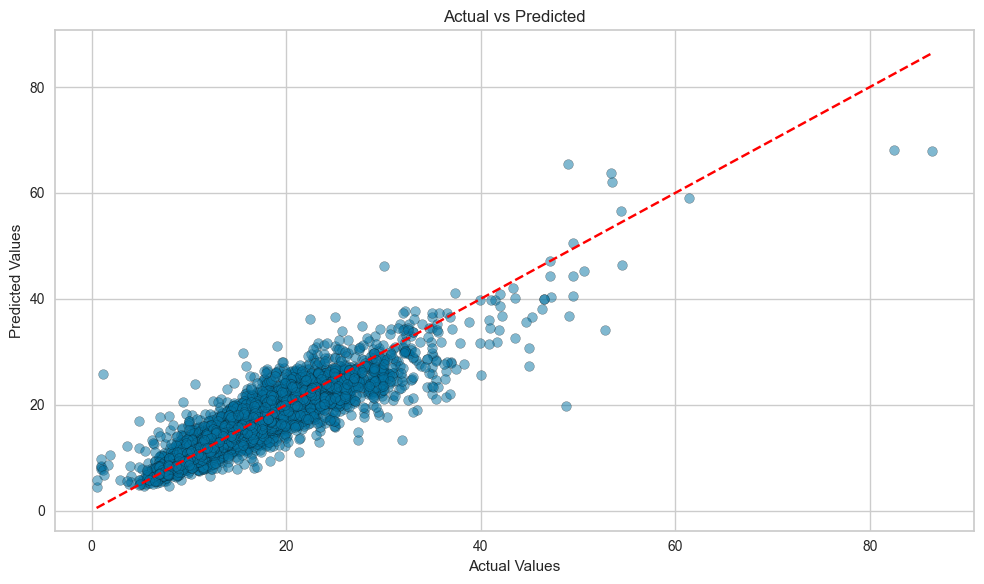

In [61]:
X_train_transformed, X_val_transformed, X_test_transformed, y_train, y_val, y_test = [
    x.to_numpy() if x is not None else None 
    for x in data_for_tuning(train_map, test_map, with_validation=True)
]

# Load saved base models
XGB_model = joblib.load("../models/XGB.sav")
RF_model = joblib.load("../models/RF.sav")

# Hold predictions (meta-features)
train_meta_features = np.zeros((X_train_transformed.shape[0], 2)) #3
test_meta_features = np.zeros((X_test_transformed.shape[0], 2)) #3

# Generate meta-features for training set (using the entire dataset)
train_meta_features[:, 0] = RF_model.predict(X_train_transformed)
train_meta_features[:, 1] = XGB_model.predict(X_train_transformed)

# Generate meta-features for test set
test_meta_features[:, 0] = RF_model.predict(X_test_transformed)
test_meta_features[:, 1] = XGB_model.predict(X_test_transformed)

# Train meta-learner (Ridge Regression for stability)
# Use cross-validation to choose the best alpha
ridge_alphas = [0.1, 0.5, 1.0, 5, 10, 25, 50, 75, 100]
meta_learner = RidgeCV(alphas=ridge_alphas, store_cv_results=True)
meta_learner.fit(train_meta_features, y_train)

print(f"Best alpha: {meta_learner.alpha_}")

preds_train = meta_learner.predict(train_meta_features)
preds_test = meta_learner.predict(test_meta_features)

# Evaluate performance
evaluate_model(y_train, y_test, preds_train, preds_test)


Different Meta-Learners were tested: 

LGBM R² = 0.8208 (deleted), XGB R² = 0.8259 (deleted), RF R² = 0.8303 (deleted), Ridge with it's R² = 0.8342 turned out to be the best. 

***In stacking, the idea is to let the meta-learner learn from the mistakes of base models rather than using raw features.***

## Feature Engineering with Model Outputs (NN Training)

868/868 ━━━━━━━━━━━━━━━━━━━━ 1s 697us/step
272/272 ━━━━━━━━━━━━━━━━━━━━ 0s 627us/step
272/272 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 5.6384 - mae: 1.4821 - mape: 10.0863
dict_keys(['loss', 'mae', 'mape', 'val_loss', 'val_mae', 'val_mape', 'learning_rate'])

dict_keys(['loss', 'mae', 'mape', 'val_loss', 'val_mae', 'val_mape', 'learning_rate'])



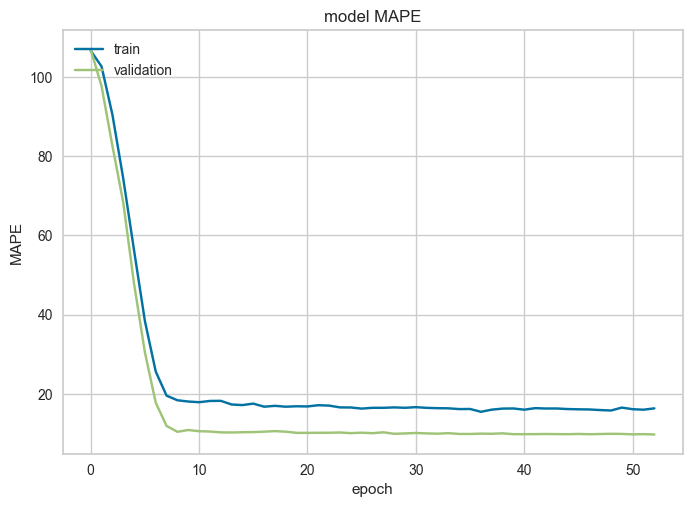

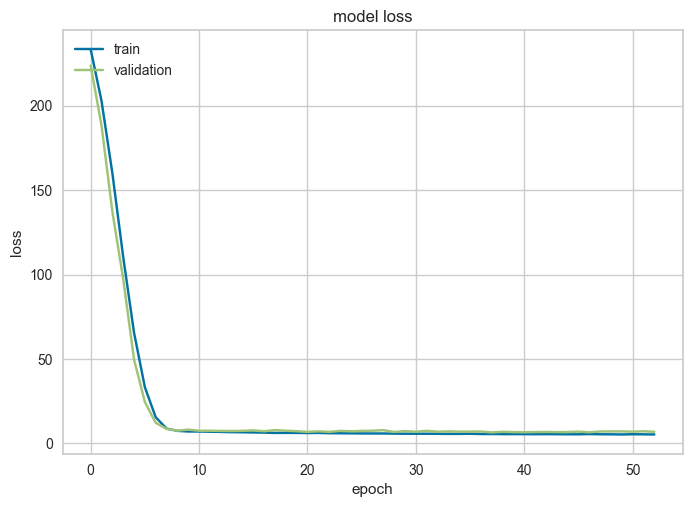


=== Train Metrics ===
 mean_absolute_error  mean_absolute_percentage_error   rmse  r2_score
              1.1257                          0.2251 1.9152    0.8762

=== Test Metrics ===
 mean_absolute_error  mean_absolute_percentage_error   rmse  r2_score
              1.4675                          0.1026 2.3277    0.8287


<Figure size 1200x800 with 0 Axes>

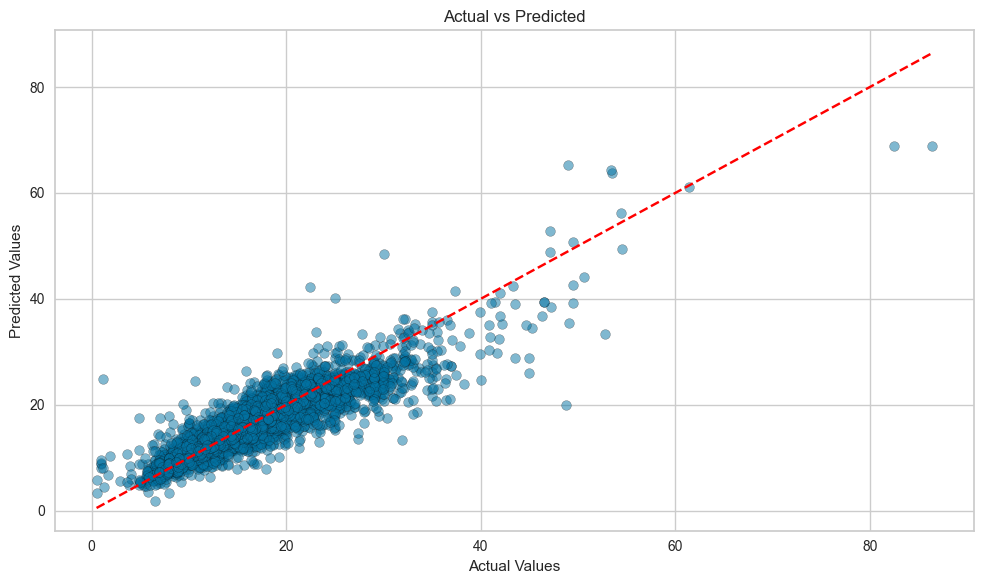

In [201]:
X_train_transformed, X_val_transformed, X_test_transformed, y_train, y_val, y_test = [
    x.to_numpy() if x is not None else None 
    for x in data_for_tuning(train_map, test_map, with_validation=True)
]

# Load pre-trained models
XGB_model = joblib.load("../models/XGB.sav")
RF_model = joblib.load("../models/RF.sav")

# Get RF predictions
rf_preds_train = RF_model.predict(X_train_transformed).reshape(-1, 1)
rf_preds_val = RF_model.predict(X_val_transformed).reshape(-1, 1) 
rf_preds_test = RF_model.predict(X_test_transformed).reshape(-1, 1)

# Get XGBoost predictions
xgb_preds_train = XGB_model.predict(X_train_transformed).reshape(-1, 1)
xgb_preds_val = XGB_model.predict(X_val_transformed).reshape(-1, 1)  
xgb_preds_test = XGB_model.predict(X_test_transformed).reshape(-1, 1)

# Append RF and XGB predictions as additional features
X_train_extended = np.concatenate([X_train_transformed, rf_preds_train, xgb_preds_train], axis=1)
X_val_extended = np.concatenate([X_val_transformed, rf_preds_val, xgb_preds_val], axis=1)  
X_test_extended = np.concatenate([X_test_transformed, rf_preds_test, xgb_preds_test], axis=1)

# Define NN Model
input_dim = X_train_extended.shape[1]

model = tf.keras.Sequential([
    Input(shape=(input_dim,)),
    
    tf.keras.layers.Dense(128),
    tf.keras.layers.Activation(tf.keras.activations.swish),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.1),

    tf.keras.layers.Dense(128, kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.Activation(tf.keras.activations.swish),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.1),

    tf.keras.layers.Dense(64, kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.Activation(tf.keras.activations.swish),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.1),
    
    tf.keras.layers.Dense(1)
])

# Compile model
optimizer = tf.keras.optimizers.AdamW(learning_rate=0.0001, weight_decay=1e-4)
model.compile(optimizer=optimizer, metrics=["mae", "mape"], loss="mse") 

# Define callbacks
early_stopping = EarlyStopping(
    monitor = "val_loss",
    verbose=1,
    patience=15,
    restore_best_weights=True
)

lr_scheduler = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=10,
    verbose=1
)

# Train model
history = model.fit(
    X_train_extended,
    y_train,
    validation_data=(X_val_extended, y_val),
    batch_size=32,
    epochs=1000,
    verbose=0,
    callbacks=[early_stopping, lr_scheduler]
)

# Generate predictions
preds_train = model.predict(X_train_extended).flatten()
preds_test = model.predict(X_test_extended).flatten()

# Evaluate model
model.evaluate(X_test_extended, y_test)

model.save("../models/NNmodel_ensemble.h5")

# Plotting models MAPE and lost during training
df_history = pd.DataFrame(history.history)

print(history.history.keys())
print()

# Plot training history
plot_history(history)

# Evaluate final model performance
evaluate_model(y_train, y_test, preds_train, preds_test)

*Neural networks benefit from rich feature representations, so adding base model predictions can serve as useful handcrafted features. Unlike stacking, where the meta-model only uses base model outputs, here the neural network can learn interactions between original features and model predictions. The predictions serve as high-level engineered features rather than a substitute for raw input.*

## Model Selection and Conclusion

### Summary of Results
In this project, we experimented with multiple models, including individual machine learning algorithms, ensemble methods, and feature engineering techniques. The key findings are:

- **XGBoost (XGB) and Random Forest (RF) were the strongest standalone models.**  
  - **XGB** achieved an R² of **0.8299** on the test set.  
  - **RF** slightly outperformed it with an R² of **0.8359**.

- **Ensemble methods improved performance over individual models.**
  - **Weighted averaging (XGB * 0.5 + RF * 0.5) achieved the highest R² = 0.8363**.
  - **Stacking with Ridge regression was competitive but did not surpass weighted averaging (R² = 0.8342).**
  - **Stacking with RF as a meta-learner achieved R² = 0.8303, with XGB achieved R² = 0.8259**, but still did not beat simple averaging (removed since it haven't beat Ridge).

- **Feature Engineering with Neural Networks showed promise.**
  - When combining raw features with XGB + RF predictions as additional inputs, a neural network achieved R² = **0.8287**.
  - Performance on NN greatly improved by advanced feature engineering, but haven't outperform tree-based models
  - NN models shows high variance in test set metric's results between multiple runs, which indicates their high sensitivity to outliers naturally present in dataset


### Final Model Selection
The best model for this task was **Ensemble Weighted Averaging (XGB + RF)**, achieving an **R² of 0.8363**, which **outperformed all individual models and stacking approaches.**  
This model also has small gap between test and train metrics, which shows good generalization capacity.

### Key Takeaways
1. **Boosted models (XGB, RF) were the best standalone learners.** RF has slightly better performance.
2. **Simple weighted ensemble averaging (XGB + RF) outperformed complex stacking approaches.** It has the best RMSE and R2 among tested models, and also has small gap between test metrics and train, which shows good generalization capacity.
3. **Feature engineering by adding model predictions as NN inputs worked well but did not outperform simpler ensembles.**
4. **Stacking with Ridge regression or RF was competitive but not superior to weighted averaging.**
5. **The models have difficulty predicting the price for very expensive housing. A further possible way forward could be to categorize expensive housing and analyze it separately.**


In [ ]:
# Quick look on a few sample predictions from the best model

# Load saved models
XGB_model = joblib.load("../models/XGB.sav")
RF_model = joblib.load("../models/RF.sav")

# Get predictions
xgb_preds_train = XGB_model.predict(X_train_transformed)
rf_preds_train = RF_model.predict(X_train_transformed)
xgb_preds_test = XGB_model.predict(X_test_transformed)
rf_preds_test = RF_model.predict(X_test_transformed)

# Assign weights
xgb_weight = 0.5  # Best MAE
rf_weight = 0.5  # Best RMSE

# Compute ensemble predictions
final_preds_train = (xgb_weight * xgb_preds_train) + (rf_weight * rf_preds_train)
final_preds_test = (xgb_weight * xgb_preds_test) + (rf_weight * rf_preds_test)

# Evaluate a few test samples
for _ in range(10):
    price = y_test[_] * X_test.iloc[_, 0]
    price_predicted = final_preds_test[_] * X_test.iloc[_, 0]
    price_difference = abs(price - price_predicted)
    print(
        f"Test Sample {_+1}: Estimated flat price differs by {price_difference:.2f} kPLN from the actual price of {price:.2f} kPLN."
    )

Test Sample 1: Estimated flat price differs by 81.47 kPLN from the actual price of 700.00 kPLN.
Test Sample 2: Estimated flat price differs by 211.09 kPLN from the actual price of 917.00 kPLN.
Test Sample 3: Estimated flat price differs by 164.56 kPLN from the actual price of 2199.00 kPLN.
Test Sample 4: Estimated flat price differs by 56.46 kPLN from the actual price of 740.00 kPLN.
Test Sample 5: Estimated flat price differs by 26.29 kPLN from the actual price of 515.00 kPLN.
Test Sample 6: Estimated flat price differs by 299.85 kPLN from the actual price of 1250.00 kPLN.
Test Sample 7: Estimated flat price differs by 52.64 kPLN from the actual price of 285.00 kPLN.
Test Sample 8: Estimated flat price differs by 30.59 kPLN from the actual price of 899.00 kPLN.
Test Sample 9: Estimated flat price differs by 12.16 kPLN from the actual price of 638.19 kPLN.
Test Sample 10: Estimated flat price differs by 36.29 kPLN from the actual price of 959.00 kPLN.
